# **Import packages**

In [ ]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier



In [ ]:
#pip install -U imbalanced-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Read data from google drive**

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/creditcard.csv'
data = pd.read_csv(file_path)
data_org = data.copy()

# ****EDA and Preprocessing****

In [ ]:
print(data)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

In [ ]:
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns')

The data has 284807 rows and 31 columns


In [ ]:
# Display information about the dataset
data.info()

# Separate legitimate and fraud transactions
legit = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

# Display summary statistics for the 'Amount' column of legitimate transactions
print("Summary Statistics for Legitimate Transactions")
print(legit['Amount'].describe())

# Display summary statistics for the 'Amount' column of fraud transactions
print("\nSummary Statistics for Fraudulent Transactions")
print(fraud['Amount'].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# **Check imbalanced Data**


In [ ]:
# Class values distribution
print(data.Class.value_counts())
print("\n")
# Portion of each class
print("The portion for not being fraud:", (data.Class.value_counts()[0] / len(data)) * 100, "\nThe portion for being fraud:", (data.Class.value_counts()[1] / len(data)) * 100)

0    284315
1       492
Name: Class, dtype: int64


The portion for not being fraud: 99.82725143693798 
The portion for being fraud: 0.1727485630620034


<function matplotlib.pyplot.show(close=None, block=None)>

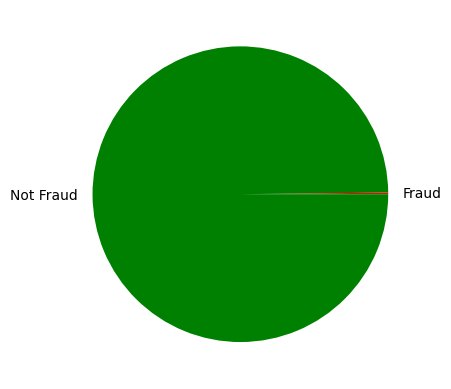

In [ ]:
# Make it visual
plt.pie([data[data["Class"] == 1].shape[0], data[data["Class"] == 0].shape[0]], labels=["Fraud", "Not Fraud"], colors=["red", "green"])
plt.show



# **Distribution of credit card transactions over time**

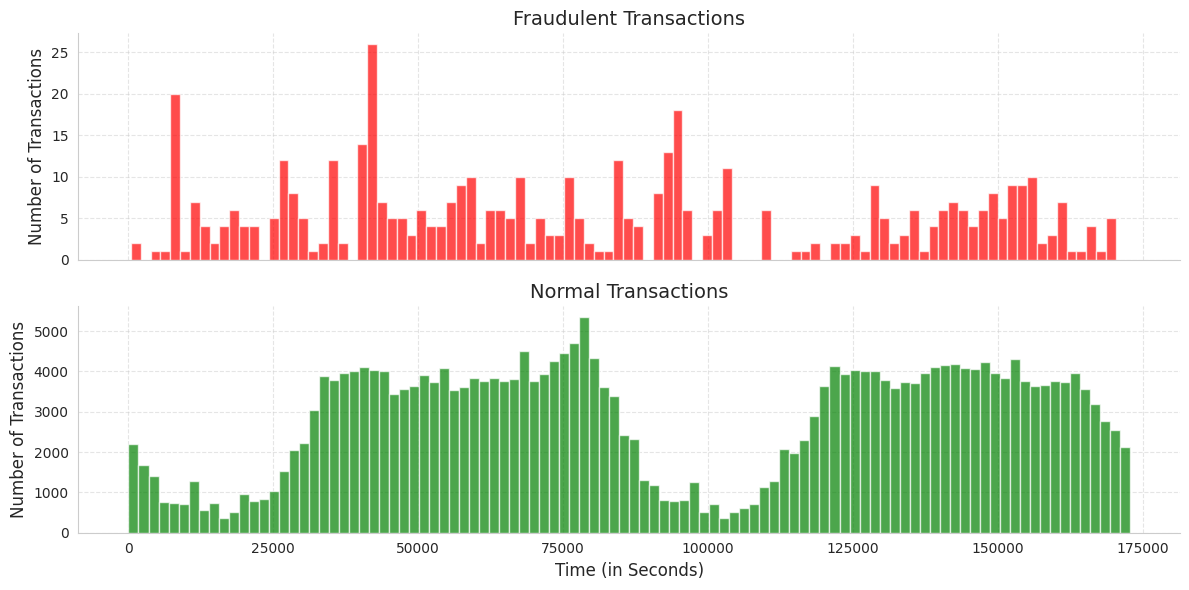

In [ ]:
# Customize the appearance of the plots
sns.set_style("whitegrid")

# Create a figure with two subplots, sharing the x-axis, and set the size
fig, (subplot1, subplot2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Define the number of bins for the histograms
num_bins = 100

# Plot the histogram for fraudulent transactions
subplot1.hist(data.Time[data.Class == 1], bins=num_bins, color='red', alpha=0.7)
subplot1.set_title('Fraudulent Transactions', fontsize=14)
subplot1.set_ylabel('Number of Transactions', fontsize=12)
subplot1.grid(True, linestyle='--', alpha=0.5)

# Plot the histogram for normal transactions
subplot2.hist(data.Time[data.Class == 0], bins=num_bins, color='green', alpha=0.7)
subplot2.set_title('Normal Transactions', fontsize=14)
subplot2.set_xlabel('Time (in Seconds)', fontsize=12)
subplot2.set_ylabel('Number of Transactions', fontsize=12)
subplot2.grid(True, linestyle='--', alpha=0.5)

# Remove the top and right spines from both subplots
for subplot in [subplot1, subplot2]:
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(False)

# Ensure proper layout and display the plot
plt.tight_layout()
plt.show()


# **Comparison of Transaction Amounts: Fraudulent vs. Normal Transactions**

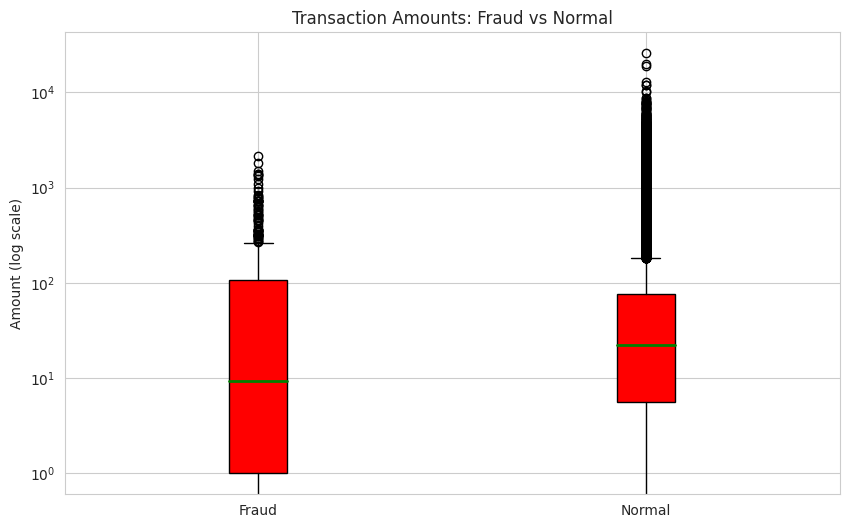

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
plt.figure(figsize=(10, 6))

# Extract data for fraud and normal transactions
fraud_amounts = data[data["Class"] == 1]["Amount"]
normal_amounts = data[data["Class"] == 0]["Amount"]

# Create a box plot with different colors
plt.boxplot([fraud_amounts, normal_amounts],
            labels=['Fraud', 'Normal'],
            patch_artist=True,  # Enable filling the boxes with color
            boxprops=dict(facecolor='red', color='black'),  # Red box for fraud
            capprops=dict(color='black'),  # Customize caps color
            whiskerprops=dict(color='black'),  # Customize whiskers color
            medianprops=dict(color='green', linewidth=2)  # Green median line for normal
           )

# Set the title and labels
plt.title('Transaction Amounts: Fraud vs Normal')
plt.ylabel('Amount (log scale)')
plt.yscale('log')

# Show the plot
plt.show()





# **Analysis of 'Amount' and 'Time' Features in Fraudulent and Non-Fraudulent Transactions**

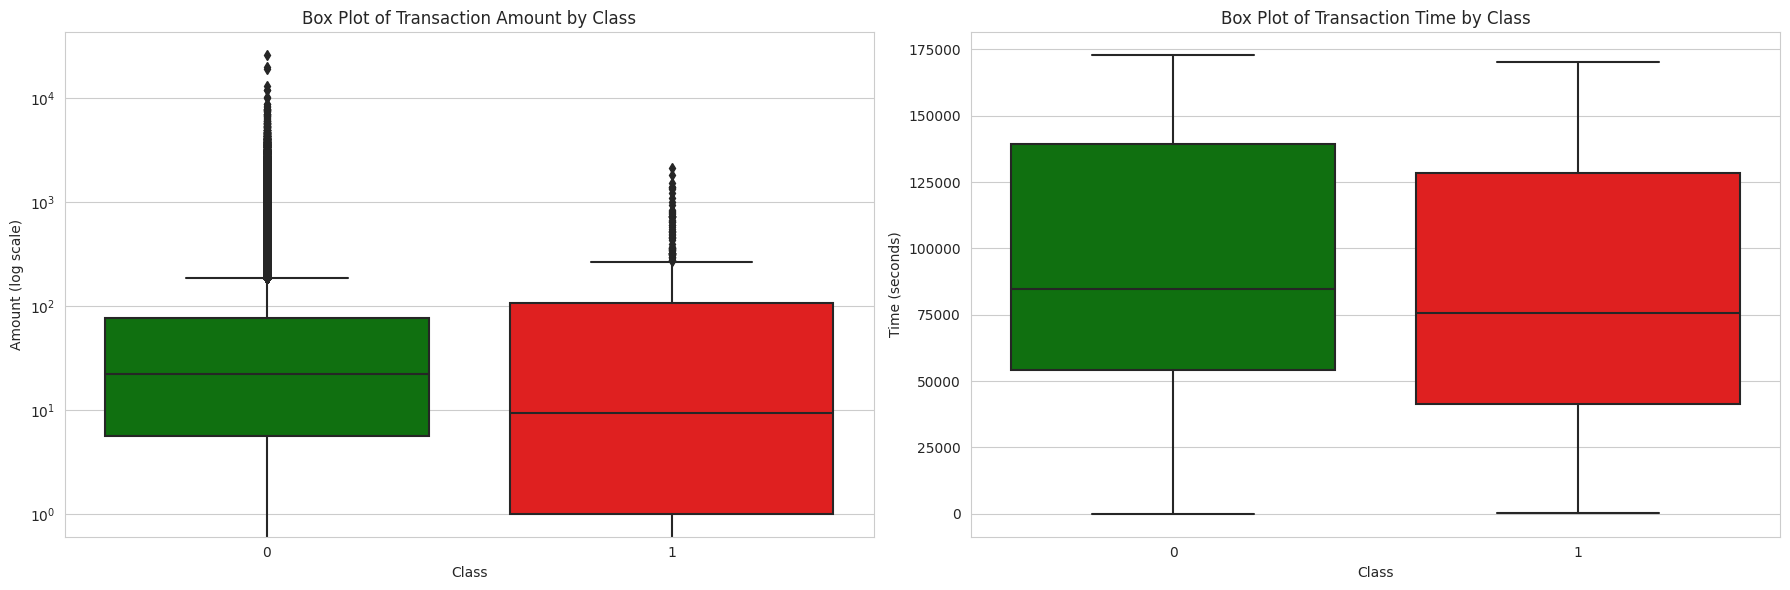

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for box plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Box plot for 'Amount' by 'Class'
sns.boxplot(x='Class', y='Amount', data=data, ax=ax[0], palette={0: 'green', 1: 'red'})
ax[0].set_title('Box Plot of Transaction Amount by Class')
ax[0].set_yscale('log')  # Using log scale due to wide range of 'Amount'
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Amount (log scale)')

# Box plot for 'Time' by 'Class'
sns.boxplot(x='Class', y='Time', data=data, ax=ax[1], palette={0: 'green', 1: 'red'})
ax[1].set_title('Box Plot of Transaction Time by Class')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Time (seconds)')

# Adjust layout
plt.tight_layout()
plt.show()


# **Calculating the correlation matrix**


Axes(0.125,0.11;0.62x0.77)


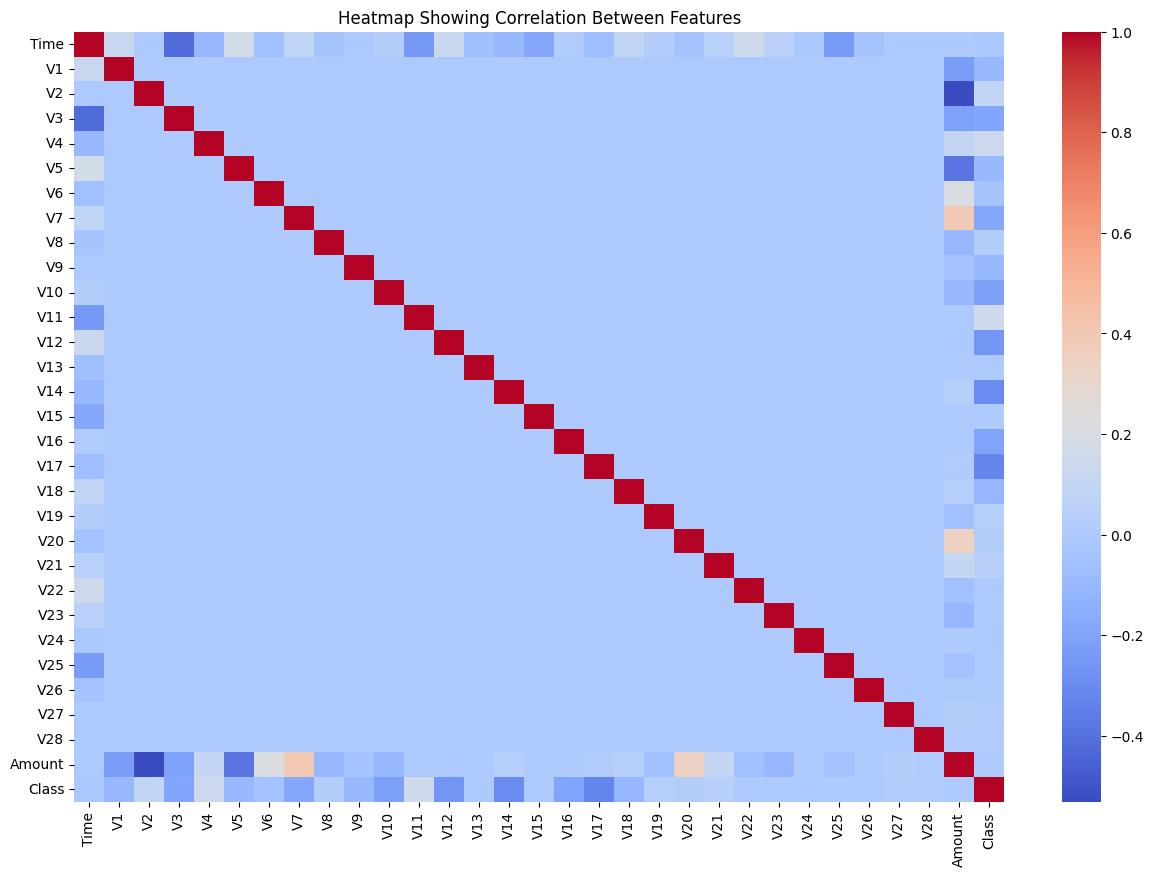

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap plot
plt.figure(figsize=(15, 10))
 sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".1f")

plt.title('Heatmap Showing Correlation Between Features')
plt.show()


In [ ]:
!pip install imbalanced-learn

# **Compare undersampling ,SMOTE & ADASYN**



Initial dataset shape {Counter(data['Class'])}
Undersampled dataset shape Counter({0: 492, 1: 492})
Oversampled dataset shape using SMOTE Counter({0: 284315, 1: 284315})
Oversampled dataset shape using ADASYN Counter({0: 284315, 1: 284298})


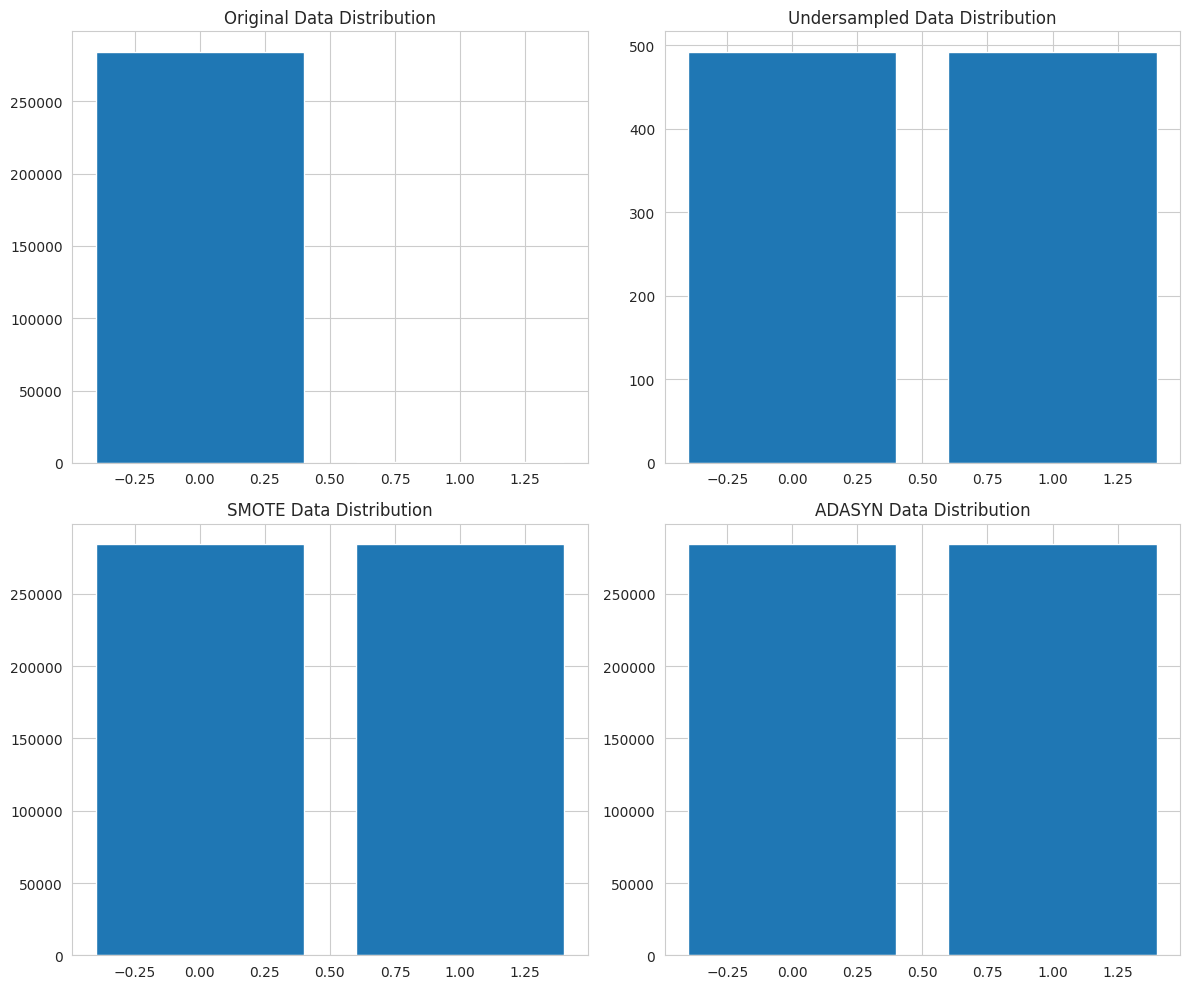

In [ ]:
# Display the initial class distribution
print("Initial dataset shape {Counter(data['Class'])}")

# Apply undersampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(data.drop('Class', axis=1), data['Class'])
print(f"Undersampled dataset shape {Counter(y_rus)}")

# Apply SMOTE for oversampling
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(data.drop('Class', axis=1), data['Class'])
print(f"Oversampled dataset shape using SMOTE {Counter(y_smote)}")

# Apply ADASYN for oversampling
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(data.drop('Class', axis=1), data['Class'])
print(f"Oversampled dataset shape using ADASYN {Counter(y_adasyn)}")

# Compare the results
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Original data distribution
ax[0, 0].bar(Counter(data['Class']).keys(), Counter(data['Class']).values())
ax[0, 0].set_title('Original Data Distribution')

# Undersampled data distribution
ax[0, 1].bar(Counter(y_rus).keys(), Counter(y_rus).values())
ax[0, 1].set_title('Undersampled Data Distribution')

# SMOTE data distribution
ax[1, 0].bar(Counter(y_smote).keys(), Counter(y_smote).values())
ax[1, 0].set_title('SMOTE Data Distribution')

# ADASYN data distribution
ax[1, 1].bar(Counter(y_adasyn).keys(), Counter(y_adasyn).values())
ax[1, 1].set_title('ADASYN Data Distribution')

plt.tight_layout()
plt.show()


# **Clean data (Checking Missing Value)**

---








In [ ]:
data.isnull().sum()



Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

outlier


# **Feature Selection using ANOVA F-statistic with SelectKBest**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

# Separate features (X) and labels (y)
X = data.drop(columns=['Class'])
y = data['Class']

# Perform feature selection using SelectKBest and ANOVA F-statistic
# You can choose the number of top features (k) based on your requirements
k_best = 10  # Adjust this value as needed
selector = SelectKBest(f_classif, k=k_best)
X_selected = selector.fit_transform(X, y)



# Split the data into training and testing sets using the selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Print the selected features
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

print(X_train.shape)

Selected Features: Index(['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'], dtype='object')
(227845, 10)



# **Standard Scaling**



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

credit_card_data = pd.DataFrame(data)

X =X_train ;
y =y_train ;

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Now, X_train_scaled and X_test_scaled contain the standardized features---------------------------------------------------------


# **Balance Data with SMOTE**

In [ ]:
#!pip install -U imbalanced-learn scikit-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#X =X_train ;
#y =y_train ;


X =X_train_scaled ;
y =y_train ;


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(y)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Number of samples after SMOTE:", len(y_train_resampled))


272615    0
191231    0
53595     0
193549    0
207723    0
         ..
131478    0
239193    0
67705     0
233557    0
155997    0
Name: Class, Length: 182276, dtype: int64
Number of samples after SMOTE: 291116


# **Splitting Dataset to Train and Test**




In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data, lbl_train, lbl_test = train_test_split(X_train_resampled, y_train_resampled,shuffle=True,stratify=y_train_resampled, test_size=0.20, random_state=0)
print(train_data.shape)
print(lbl_test.shape)

(232892, 10)
(58224,)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
algorithms_name=['LogisticRegression','Decision Tree','Naive Bayes',"KNN",'Random Forest',"Adaboost",'LSTM','CNN','CNN+LSTM'  ]
alg_num=len(algorithms_name)
accuracy_array=np.zeros(alg_num)
precision_array=np.zeros(alg_num)
recall_array=np.zeros(alg_num)
f1_score_array=np.zeros(alg_num)
roc_auc_array=np.zeros(alg_num)

algorithms_name_Hyper=['LogisticRegression Hyper','Decision Tree Hyper','Naive Bayes Hyper',"KNN Hyper",'Random Forest Hyper',"Adaboost Hyper",'LSTM Hyper','CNN Hyper','CNN+LSTM Hyper' ]
alg_num_Hyper=len(algorithms_name_Hyper)
accuracy_array_Hyper=np.zeros(alg_num_Hyper)
precision_array_Hyper=np.zeros(alg_num_Hyper)
recall_array_Hyper=np.zeros(alg_num_Hyper)
f1_score_array_Hyper=np.zeros(alg_num_Hyper)
roc_auc_array_Hyper=np.zeros(alg_num_Hyper)






In [ ]:
def plot_cfm(test_label,y_pred,clf_name):
  label_names=["No Fraud","Fraud"]


  cm=confusion_matrix(test_label, y_pred)
  cm_df = pd.DataFrame(cm,
                      index = label_names,
                      columns = label_names)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm_df, annot=True,cmap = "Blues", fmt='g' )
  plt.title('Confusion Matrix of '+clf_name, fontweight='bold')
  plt.ylabel('True Label', fontweight='bold')
  plt.xlabel('Predicted Label', fontweight='bold')
  plt.show()

# **Logistic Regression**

Accuracy: 0.9996350286609845
Precision: 0.9992676832945636
Recall: 1.0
F1 Score: 0.9996337075262329
AUC-ROC: 0.9999077991995069


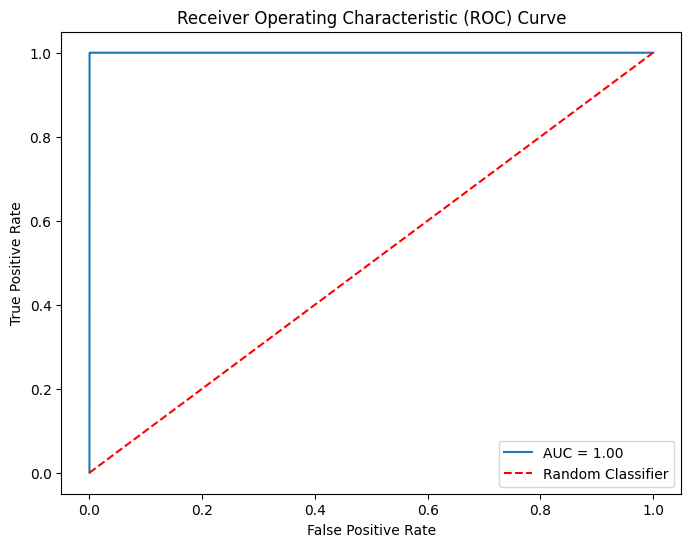

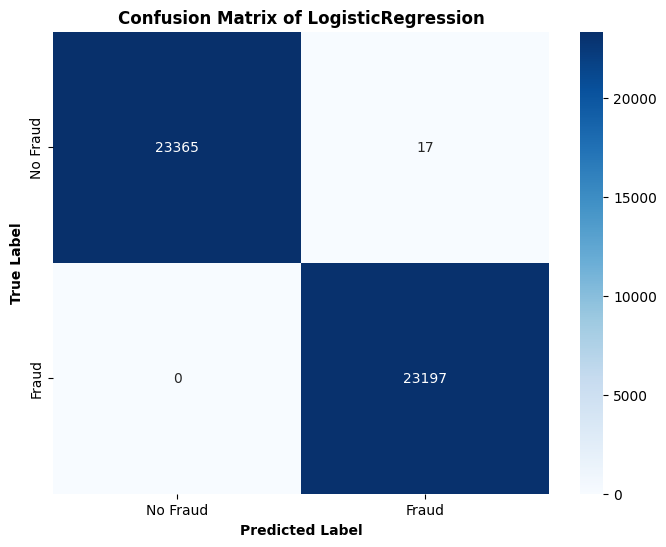

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data, lbl_train, test_size=0.2, random_state=42)

# Create and train a Random Forest model (you can try other models as well)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate evaluation metrics
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("Precision:", pre)
print("Recall:", rec)
print("F1 Score:", f1)
print("AUC-ROC:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_curve:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

K = 0
# save to array
accuracy_array[K]=acc
precision_array[K]= pre
recall_array[K]= rec
f1_score_array[K]= f1
roc_auc_array[K]=roc_auc

# Print confusion matrix

plot_cfm(y_test,y_pred,"LogisticRegression")

# **Logistic Regression hyperparameter tuning using GridSearchCV**

Best Model Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9996564975632796
Precision: 0.9993967857296738
Recall: 0.999913781954563
F1 Score: 0.999655216997802
AUC-ROC: 0.9999093995173464


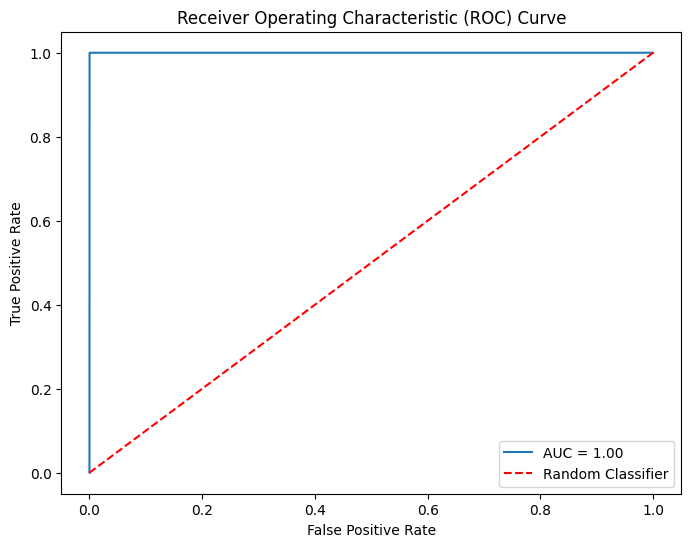

Confusion Matrix:
[[23368    14]
 [    2 23195]]


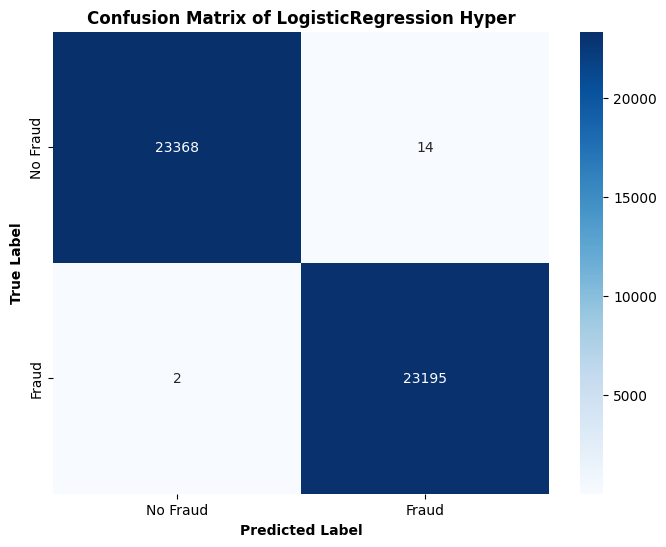

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(train_data, lbl_train, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest model
model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from the search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)

print("Best Model Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_curve:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

P=0
# save to array
accuracy_array_Hyper[P]=accuracy
precision_array_Hyper[P]= precision
recall_array_Hyper[P]= recall
f1_score_array_Hyper[P]= f1
roc_auc_array_Hyper[P]=roc_auc


# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plot_cfm(y_test,y_pred,"LogisticRegression Hyper")

#***Decision Tree Classifier***

accuracy: 0.998 
precision : 0.998 
recall: 0.998
f1 score: 0.998


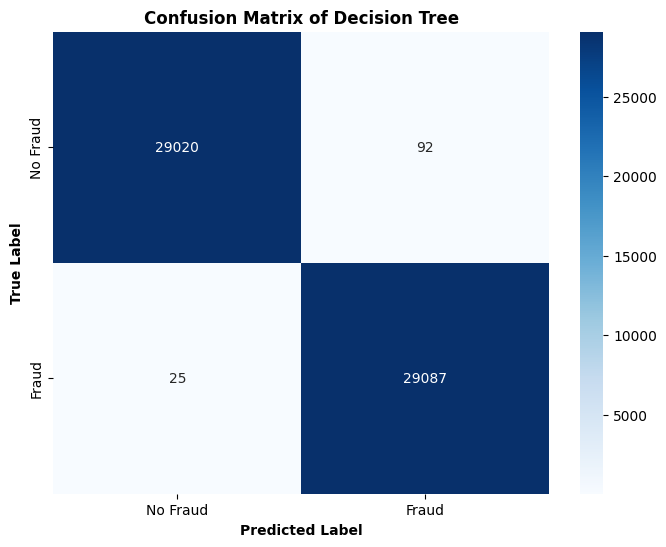

In [ ]:
#tf_randomness_control(0)
from sklearn.metrics import accuracy_score
classifier_DT = DecisionTreeClassifier()
classifier_DT.fit(train_data , lbl_train)
Test_predict = classifier_DT.predict(test_data )
Con_matrix=confusion_matrix(lbl_test, Test_predict)

classfi_report=classification_report(lbl_test, Test_predict,output_dict=True)

acc=accuracy_score(lbl_test, Test_predict)
pre=classfi_report['macro avg']['precision']
rec= classfi_report['macro avg']['recall']
f1=classfi_report['macro avg']['f1-score']
print('accuracy: %.3f ' % acc)
print('precision : %.3f '%pre)
print('recall: %.3f'%rec)
print('f1 score: %.3f'%f1)


K = 1
# save to array
accuracy_array[K]=acc
precision_array[K]= pre
recall_array[K]= rec
f1_score_array[K]= f1
plot_cfm(lbl_test,Test_predict,"Decision Tree")

#**Decision Tree Classifier hyperparameter tuning using RandomizedSearchCV**

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'max_depth': 40}
Accuracy: 0.998 
Precision: 0.998 
Recall: 0.998
F1 score: 0.998


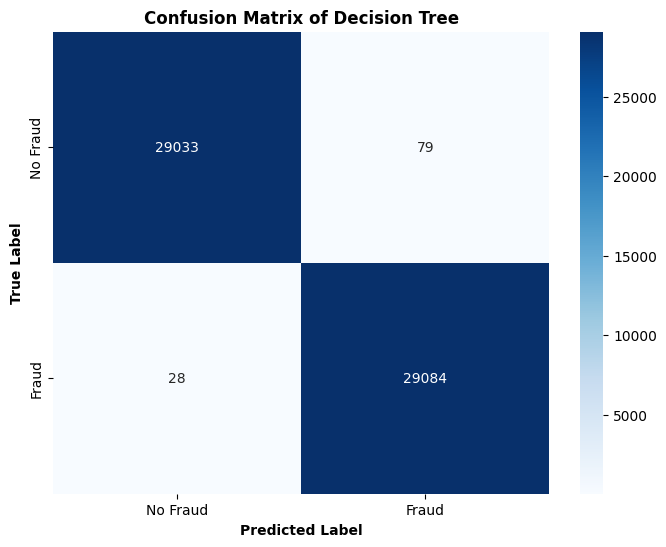

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Define the Decision Tree classifier
classifier_DT = DecisionTreeClassifier()

# Define the hyperparameter distribution for tuning
param_dist = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    # Add more hyperparameters for tuning if needed
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    classifier_DT, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42
)
random_search.fit(train_data, lbl_train)

# Get the best estimator from the random search
best_classifier = random_search.best_estimator_

# Make predictions on the test set
Test_predict = best_classifier.predict(test_data)

# Evaluate the model
Con_matrix = confusion_matrix(lbl_test, Test_predict)
classfi_report = classification_report(lbl_test, Test_predict, output_dict=True)

# Extract metrics
acc = accuracy_score(lbl_test, Test_predict)
pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']

print("Best hyperparameters:", random_search.best_params_)
print('Accuracy: %.3f ' % acc)
print('Precision: %.3f ' % pre)
print('Recall: %.3f' % rec)
print('F1 score: %.3f' % f1)

# Save metrics to arrays if needed
accuracy_array[K] = acc
precision_array[K] = pre
recall_array[K] = rec
f1_score_array[K] = f1

# Plot confusion matrix if needed
plot_cfm(lbl_test, Test_predict, "Decision Tree")


#**Naive Bayes Classifier**

accuracy: 0.998 
precision : 0.925 
recall: 0.916
f1 score: 0.916


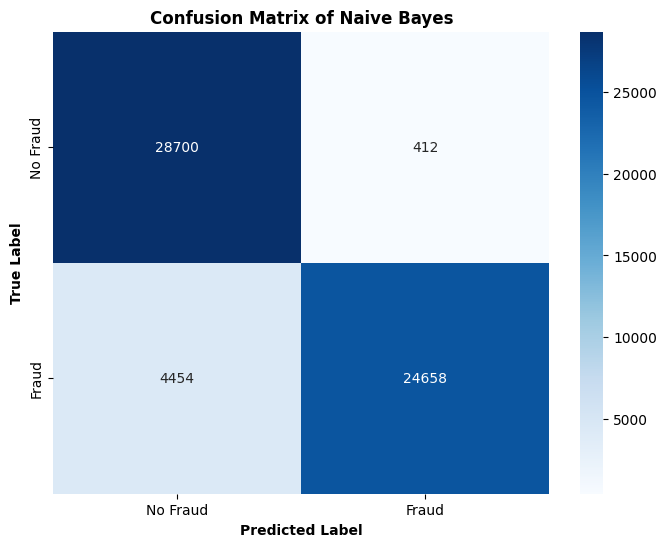

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

classifier_NB = GaussianNB()
classifier_NB.fit(train_data, lbl_train)
Test_predict = classifier_NB.predict(test_data)
Con_matrix = confusion_matrix(lbl_test, Test_predict)

classfi_report = classification_report(lbl_test, Test_predict, output_dict=True)

pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']
print('accuracy: %.3f ' % acc)
print('precision : %.3f ' % pre)
print('recall: %.3f' % rec)
print('f1 score: %.3f' % f1)

K=1
# save to array
accuracy_array[K]=acc
precision_array[K]= pre
recall_array[K]= rec
f1_score_array[K]= f1

plot_cfm(lbl_test,Test_predict,"Naive Bayes")

#**Naive Bayes Classifier hyperparameter using GridSearchCV**

accuracy: 0.917 
precision : 0.926 
recall: 0.917
f1 score: 0.916
accuracy: 0.917 
precision : 0.863 
recall: 0.992
f1 score: 0.923


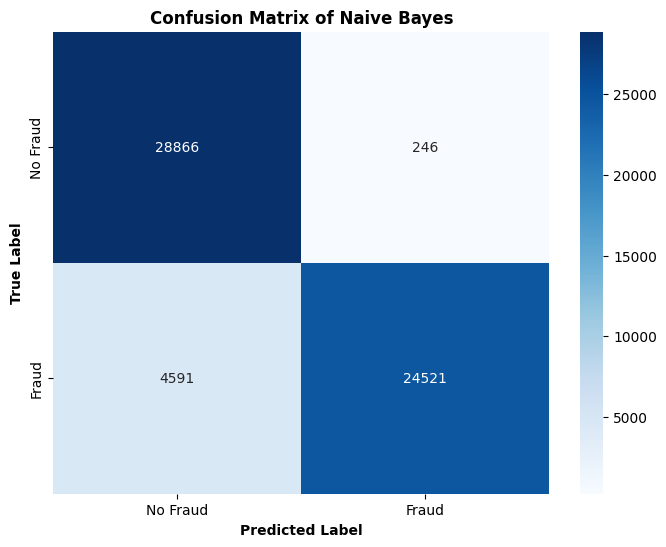

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming train_data, lbl_train, test_data, lbl_test are already defined

# Hyperparameter tuning using GridSearchCV
parameters = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

classifier_NB = GaussianNB()
grid_search = GridSearchCV(classifier_NB, parameters, cv=5)
grid_search.fit(train_data, lbl_train)

best_NB = grid_search.best_estimator_

Test_predict = best_NB.predict(test_data)
Con_matrix = confusion_matrix(lbl_test, Test_predict)

classfi_report = classification_report(lbl_test, Test_predict, output_dict=True)

acc = classfi_report['accuracy']
pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']

print('accuracy: %.3f ' % acc)
print('precision : %.3f ' % pre)
print('recall: %.3f' % rec)
print('f1 score: %.3f' % f1)

# Adjust the decision threshold
threshold = 0.5  # You can adjust this threshold based on your needs
Test_predict = (best_NB.predict_proba(test_data)[:, 1] > threshold).astype(int)

Con_matrix = confusion_matrix(lbl_test, Test_predict)

acc = (Con_matrix[0, 0] + Con_matrix[1, 1]) / np.sum(Con_matrix)
pre = Con_matrix[0, 0] / (Con_matrix[0, 0] + Con_matrix[1, 0])  # Precision for class 0 (not fraud)
rec = Con_matrix[0, 0] / (Con_matrix[0, 0] + Con_matrix[0, 1])  # Recall for class 0 (not fraud)
f1 = 2 * (pre * rec) / (pre + rec)

print('accuracy: %.3f ' % acc)
print('precision : %.3f ' % pre)
print('recall: %.3f' % rec)
print('f1 score: %.3f' % f1)

K = 1
# Save to array
accuracy_array[K] = acc
precision_array[K] = pre
recall_array[K] = rec
f1_score_array[K] = f1

plot_cfm(lbl_test, Test_predict, "Naive Bayes")


#**KNN Classifier**

accuracy: 0.917 
precision : 0.998 
recall: 0.998
f1 score: 0.998


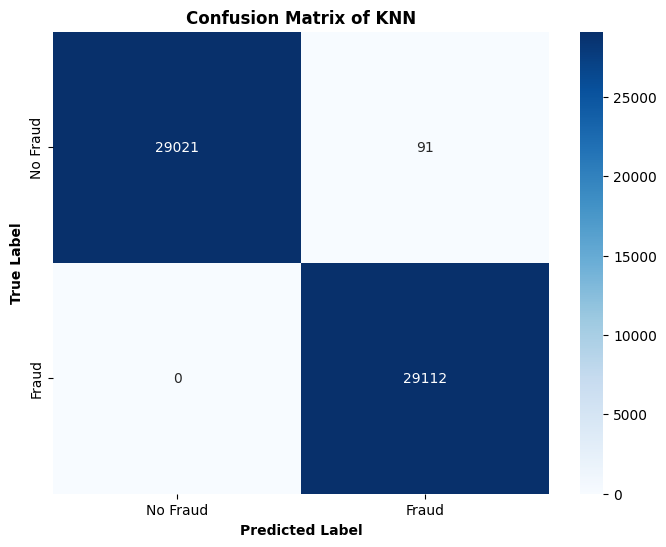

In [ ]:
classifier_KNN = KNeighborsClassifier( )
classifier_KNN.fit(train_data , lbl_train)
Test_predict = classifier_KNN.predict(test_data )
Con_matrix=confusion_matrix(lbl_test, Test_predict)

classfi_report=classification_report(lbl_test, Test_predict,output_dict=True)

pre=classfi_report['macro avg']['precision']
rec= classfi_report['macro avg']['recall']
f1=classfi_report['macro avg']['f1-score']
print('accuracy: %.3f ' % acc)
print('precision : %.3f '%pre)
print('recall: %.3f'%rec)
print('f1 score: %.3f'%f1)

K=2
# save to array
accuracy_array[K]=acc
precision_array[K]= pre
recall_array[K]= rec
f1_score_array[K]= f1
plot_cfm(lbl_test,Test_predict,"KNN")

#**KNN Classifier hyperparameters using GridSearchCV**


Best Hyperparameters: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Accuracy: 0.999 
Precision: 0.999 
Recall: 0.999
F1 Score: 0.999


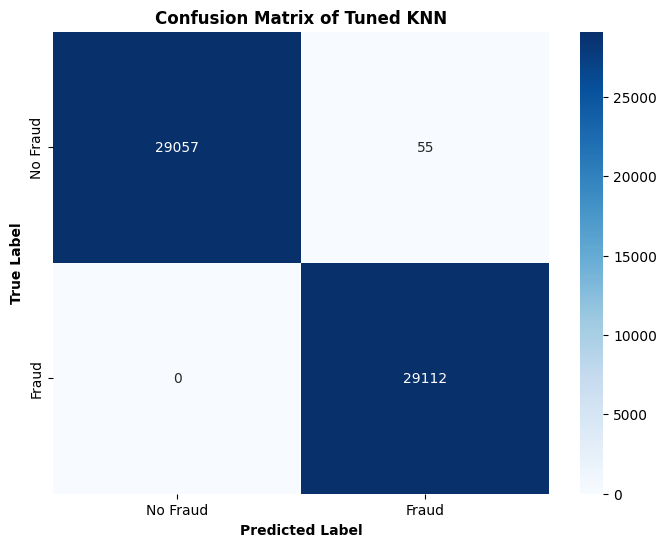

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Adjust as needed
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Create a KNN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_data, lbl_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(train_data, lbl_train)

# Predict on the test set
test_predict = best_knn.predict(test_data)

# Evaluate the model
con_matrix = confusion_matrix(lbl_test, test_predict)
classfi_report = classification_report(lbl_test, test_predict, output_dict=True)

acc = classfi_report['accuracy']
pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']

print('Best Hyperparameters:', best_params)
print('Accuracy: %.3f ' % acc)
print('Precision: %.3f ' % pre)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

# Plot confusion matrix
plot_cfm(lbl_test, test_predict, "Tuned KNN")


#**Random Forest Classifier**

accuracy: 0.998 
precision : 1.000 
recall: 1.000
f1 score: 1.000


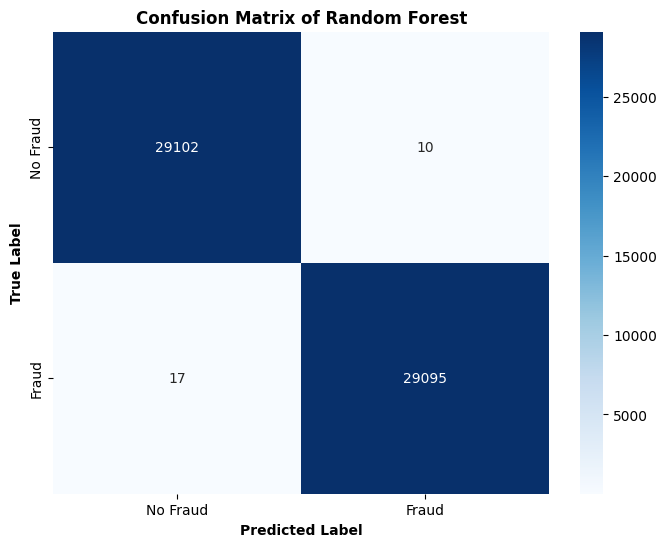

In [ ]:
classifier_RF = RandomForestClassifier(n_estimators=4)
classifier_RF.fit(train_data , lbl_train)
Test_predict = classifier_RF.predict(test_data )
Con_matrix=confusion_matrix(lbl_test, Test_predict)

classfi_report=classification_report(lbl_test, Test_predict,output_dict=True)

pre=classfi_report['macro avg']['precision']
rec= classfi_report['macro avg']['recall']
f1=classfi_report['macro avg']['f1-score']
print('accuracy: %.3f ' % acc)
print('precision : %.3f '%pre)
print('recall: %.3f'%rec)
print('f1 score: %.3f'%f1)

K=3
# save to array
accuracy_array[K]=acc
precision_array[K]= pre
recall_array[K]= rec
f1_score_array[K]= f1

plot_cfm(lbl_test,Test_predict,"Random Forest")

#**Random Forest Classifier hyperparameter Using RandomizedSearchCV**

Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}
Accuracy: 1.000 
Precision: 1.000 
Recall: 1.000
F1 Score: 1.000


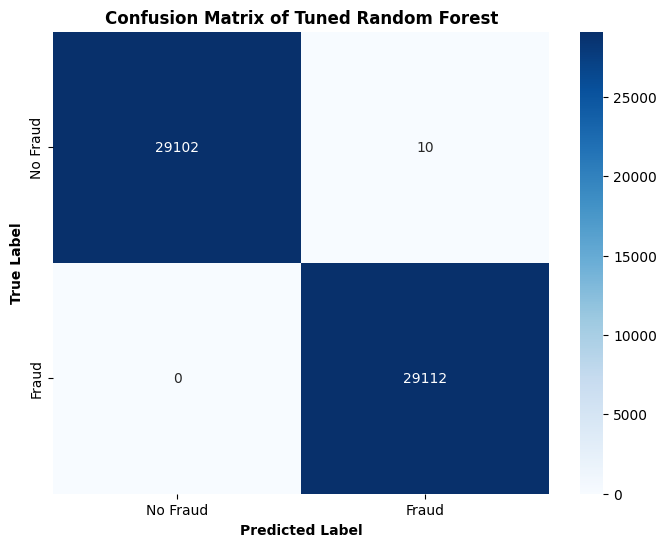

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Use RandomizedSearchCV for a faster search
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1
)
random_search.fit(train_data, lbl_train)

# Get the best parameters
best_params = random_search.best_params_

# Train the model with the best hyperparameters
best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(train_data, lbl_train)

# Predict on the test set
test_predict = best_rf_classifier.predict(test_data)

# Evaluate the model
con_matrix = confusion_matrix(lbl_test, test_predict)
classfi_report = classification_report(lbl_test, test_predict, output_dict=True)

acc = classfi_report['accuracy']
pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']

print('Best Hyperparameters:', best_params)
print('Accuracy: %.3f ' % acc)
print('Precision: %.3f ' % pre)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

# Plot confusion matrix
plot_cfm(lbl_test, test_predict, "Tuned Random Forest")


#**AdaBoost Classifier**

accuracy: 0.944 
precision : 0.945 
recall: 0.944
f1 score: 0.944


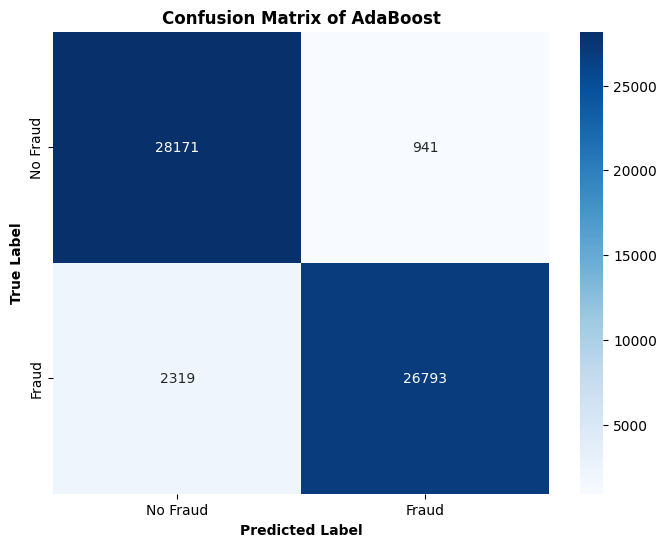

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Define the AdaBoostClassifier with a different number of estimators
classifier_Ada = AdaBoostClassifier(n_estimators=10, random_state=0)  # Change the number of estimators as needed
classifier_Ada.fit(train_data, lbl_train)
Test_predict = classifier_Ada.predict(test_data)
Con_matrix = confusion_matrix(lbl_test, Test_predict)

classfi_report = classification_report(lbl_test, Test_predict, output_dict=True)

acc = classfi_report['accuracy']
pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']

print('accuracy: %.3f ' % acc)
print('precision : %.3f ' % pre)
print('recall: %.3f' % rec)
print('f1 score: %.3f' % f1)

K = 4
# save to array
accuracy_array[K] = acc
precision_array[K] = pre
recall_array[K] = rec
f1_score_array[K] = f1

# Assuming plot_cfm function is defined
plot_cfm(lbl_test, Test_predict, "AdaBoost")


#**AdaBoost Classifier hyperparameters using GridSearchCV**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best accuracy: 0.968 
Best precision: 0.968 
Best recall: 0.968 
Best f1 score: 0.968 


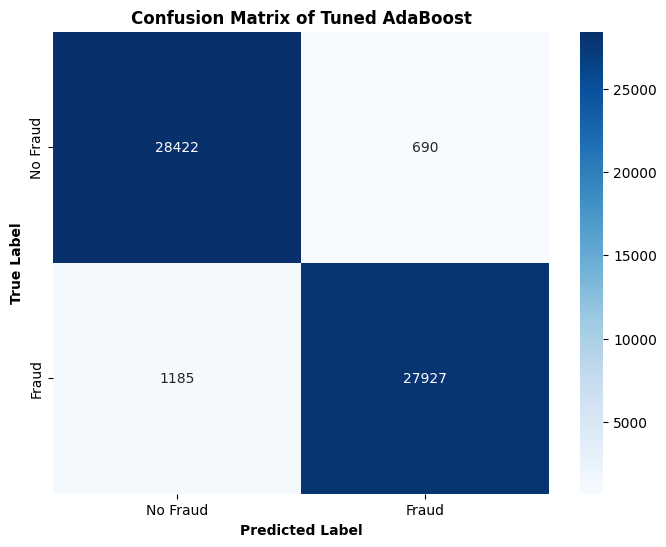

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the AdaBoostClassifier
base_classifier = AdaBoostClassifier(random_state=0)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Add more values or adjust the range as needed
    # Add other hyperparameters you want to tune
}

# Define the scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

# Create GridSearchCV
grid_search = GridSearchCV(
    base_classifier,
    param_grid=param_grid,
    scoring=scoring_metrics,
    refit='accuracy',  # Choose the primary metric for refitting the best model
    cv=5,  # Adjust the number of cross-validation folds as needed
    verbose=1
)

# Fit the GridSearchCV to your data
grid_search.fit(train_data, lbl_train)

# Get the best estimator
best_classifier = grid_search.best_estimator_

# Evaluate the best classifier on the test set
best_test_predict = best_classifier.predict(test_data)

# Print the confusion matrix and classification report for the best model
best_con_matrix = confusion_matrix(lbl_test, best_test_predict)
best_classfi_report = classification_report(lbl_test, best_test_predict, output_dict=True)

# Extract metrics for printing
best_acc = best_classfi_report['accuracy']
best_pre = best_classfi_report['macro avg']['precision']
best_rec = best_classfi_report['macro avg']['recall']
best_f1 = best_classfi_report['macro avg']['f1-score']

# Print the results
print('Best accuracy: %.3f ' % best_acc)
print('Best precision: %.3f ' % best_pre)
print('Best recall: %.3f ' % best_rec)
print('Best f1 score: %.3f ' % best_f1)

# Plot the confusion matrix for the best model
plot_cfm(lbl_test, best_test_predict, "Tuned AdaBoost")


**LSTM**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 300)               30300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               60200     
                                                                 
 dense_6 (Dense)             (None, 50)                10050     
                                                                 
 dense_7 (Dense)             (None, 2)                 102       
                                                                 
Total params: 141452 (552.55 KB)
Trainable params: 141

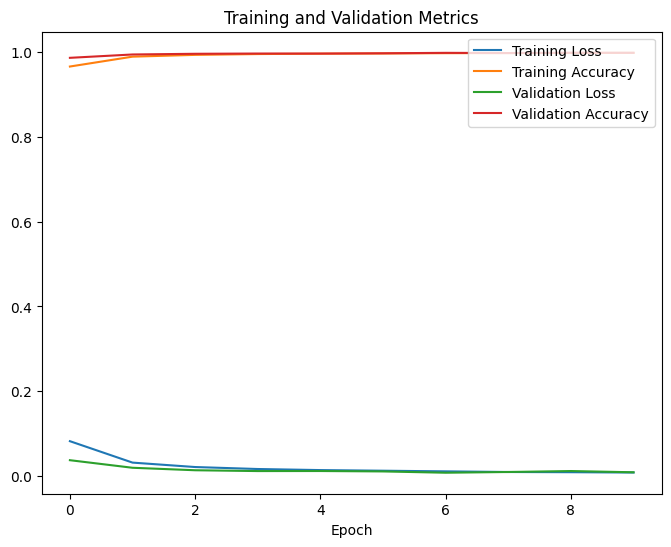

1820/1820 - 8s - 8s/epoch - 5ms/step
Accuracy: 0.999 
Precision: 0.999 
Recall: 0.999
F1 Score: 0.999


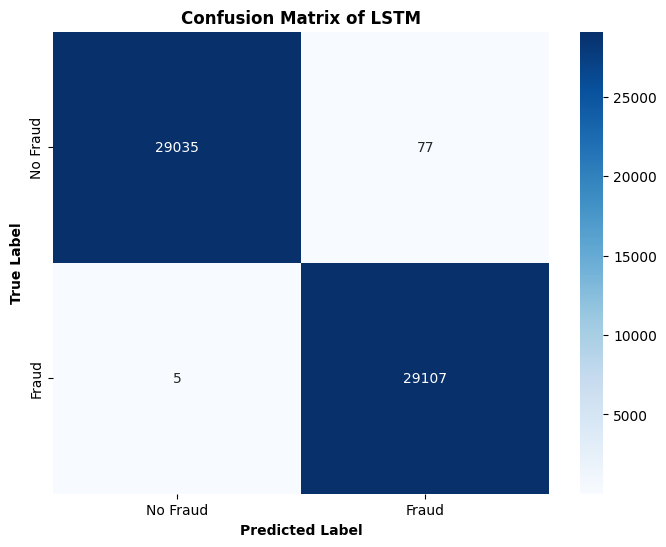

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report



# Build a simple LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, input_shape=(train_data.shape[1], 1)))
lstm_model.add(Dense(units=300, activation="relu"))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units=200, activation="relu"))
lstm_model.add(Dense(units=50, activation="relu"))
lstm_model.add(Dense(units=2, activation="softmax"))

# Compile the model with default settings
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Display model architecture
lstm_model.summary()

# Train the model
lstm_model_hist = lstm_model.fit(train_data, lbl_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot training history
loss = lstm_model_hist.history['loss']
accuracy = lstm_model_hist.history['accuracy']
val_loss = lstm_model_hist.history['val_loss']
val_accuracy = lstm_model_hist.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), accuracy, label='Training Accuracy')


plt.legend(loc='upper right')
plt.title('Training and Validation Metrics')
plt.xlabel("Epoch")
plt.show()

# Evaluate the model on the test set
y_pred_lstm = lstm_model.predict(test_data, verbose=2)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
acc = accuracy_score(lbl_test, y_pred_lstm)
classfi_report = classification_report(lbl_test, y_pred_lstm, output_dict=True)
pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']

print('Accuracy: %.3f ' % acc)
print('Precision: %.3f ' % pre)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

K=5
# Save metrics to arrays
accuracy_array[K] = acc
precision_array[K] = pre
recall_array[K] = rec
f1_score_array[K] = f1

# Plot confusion matrix
plot_cfm(lbl_test, y_pred_lstm, "LSTM")


#**LSTM with hyperparameter**

In [ ]:
pip install numpy matplotlib scikit-learn seaborn keras

In [ ]:
pip install keras


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
!pip install --upgrade tensorflow scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


#**LSTM with hyperparameter**

1820/1820 - 7s - 7s/epoch - 4ms/step
Best Model Accuracy: 0.998 
Best Model Precision: 0.998 
Best Model Recall: 0.998
Best Model F1 Score: 0.998


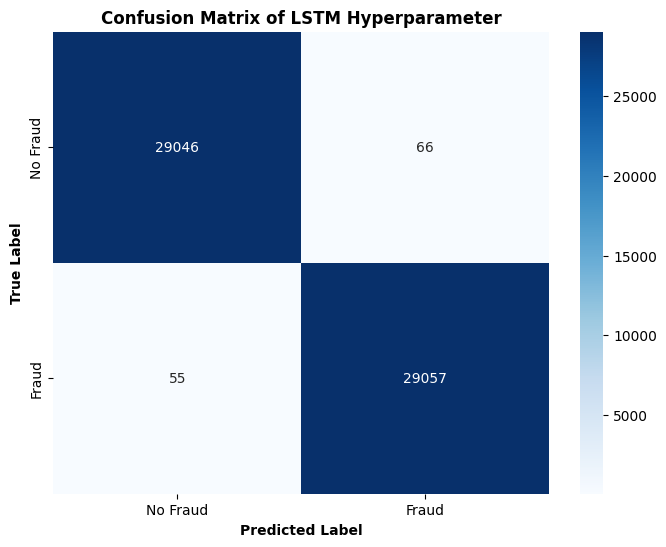

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Function to create the LSTM model
def create_lstm_model(units=100, dense_units1=300, dropout_rate=0.5, dense_units2=200, dense_units3=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(train_data.shape[1], 1)))
    model.add(Dense(units=dense_units1, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units2, activation="relu"))
    model.add(Dense(units=dense_units3, activation="relu"))
    model.add(Dense(units=2, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    return model

# Define the parameter grid
param_dist = {
    'units': [50, 100, 150],
    'dense_units1': [200, 300, 400],
    'dropout_rate': [0.3, 0.5, 0.7],
    'dense_units2': [100, 200, 300],
    'dense_units3': [30, 50, 80],
    'optimizer': ['adam', 'rmsprop']
}

# Manually perform RandomizedSearchCV
best_score = 0
best_params = {}

for _ in range(10):  # You can adjust the number of iterations (n_iter)
    current_params = {param: np.random.choice(values) for param, values in param_dist.items()}
    current_model = create_lstm_model(**current_params)

    current_model.fit(train_data, lbl_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    score = current_model.evaluate(test_data, lbl_test, verbose=0)[1]

    if score > best_score:
        best_score = score
        best_params = current_params

# Use the best model for evaluation
best_lstm_model = create_lstm_model(**best_params)
best_lstm_model.fit(train_data, lbl_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the best model on the test set
y_pred_best = best_lstm_model.predict(test_data, verbose=2)
y_pred_best = np.argmax(y_pred_best, axis=1)
acc_best = accuracy_score(lbl_test, y_pred_best)
classfi_report_best = classification_report(lbl_test, y_pred_best, output_dict=True)
pre_best = classfi_report_best['macro avg']['precision']
rec_best = classfi_report_best['macro avg']['recall']
f1_best = classfi_report_best['macro avg']['f1-score']

print('Best Model Accuracy: %.3f ' % acc_best)
print('Best Model Precision: %.3f ' % pre_best)
print('Best Model Recall: %.3f' % rec_best)
print('Best Model F1 Score: %.3f' % f1_best)

# Plot confusion matrix
plot_cfm(lbl_test, y_pred_best, "LSTM Hyperparameter")


**CNN model**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 64)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 300)              

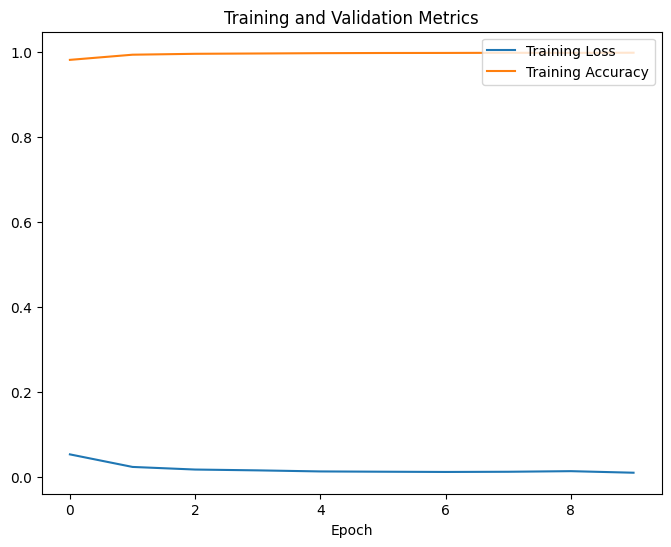

1820/1820 - 3s - 3s/epoch - 2ms/step
Accuracy: 0.998 
Precision: 0.998 
Recall: 0.998
F1 Score: 0.998


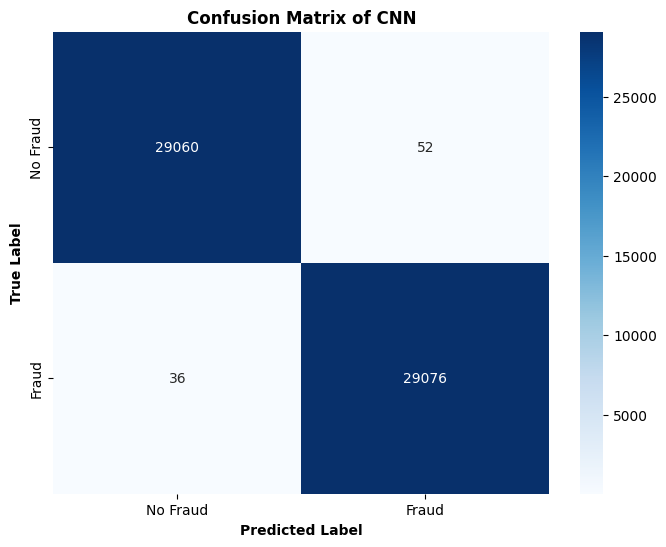

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# Build a simple CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_data.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=300, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=200, activation='relu'))
cnn_model.add(Dense(units=50, activation='relu'))
cnn_model.add(Dense(units=2, activation='softmax'))

# Compile the model with default settings
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Display model architecture
cnn_model.summary()

# Train the model
cnn_model_hist = cnn_model.fit(train_data, lbl_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot training history
loss = cnn_model_hist.history['loss']
accuracy = cnn_model_hist.history['accuracy']
val_loss = cnn_model_hist.history['val_loss']
val_accuracy = cnn_model_hist.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), accuracy, label='Training Accuracy')

plt.legend(loc='upper right')
plt.title('Training and Validation Metrics')
plt.xlabel("Epoch")
plt.show()

# Evaluate the model on the test set
y_pred_cnn = cnn_model.predict(test_data, verbose=2)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
acc = accuracy_score(lbl_test, y_pred_cnn)
classfi_report = classification_report(lbl_test, y_pred_cnn, output_dict=True)
pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']

print('Accuracy: %.3f ' % acc)
print('Precision: %.3f ' % pre)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

K = 5
# Save metrics to arrays
accuracy_array[K] = acc
precision_array[K] = pre
recall_array[K] = rec
f1_score_array[K] = f1

# Plot confusion matrix
plot_cfm(lbl_test, y_pred_cnn, "CNN")


CNN + Hyperparameter

2426/2426 [==============================] - 10s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-12-66fdcd1cc0fd>", line 39, in fit
    self.model = create_cnn_model(self.filters1, self.kernel_size1, self.filters2, self.kernel_size2,
  File "<ipython-input-12-66fdcd1cc0fd>", line 14, in create_cnn_model
    model.add(MaxPooling1D(pool_size=2))
  File "/usr/local/lib/python3.10/dist-packag

Best Parameters:  {'kernel_size2': 3, 'kernel_size1': 3, 'filters2': 128, 'filters1': 128, 'dropout_rate': 0.5, 'dense_units3': 50, 'dense_units2': 100, 'dense_units1': 300}
Best Accuracy:  0.9983726378658142
1820/1820 [==============================] - 3s 2ms/step
Best Model - Accuracy: 0.998 
Best Model - Precision: 0.998 
Best Model - Recall: 0.998
Best Model - F1 Score: 0.998


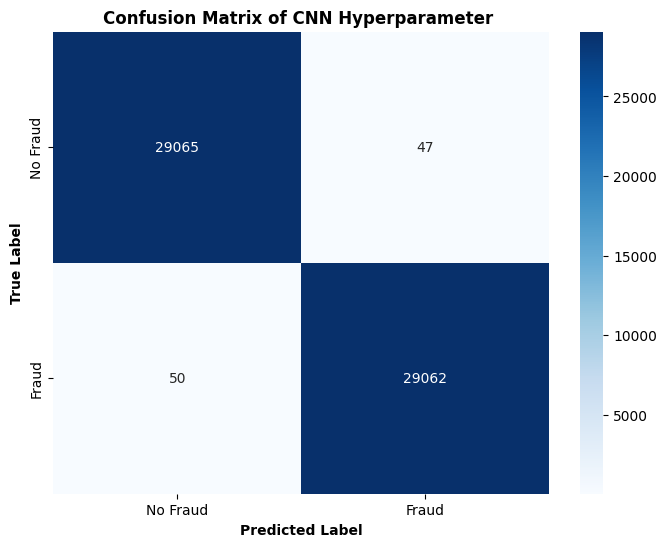

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report

# Define the CNN model as a function
def create_cnn_model(filters1, kernel_size1, filters2, kernel_size2, dense_units1, dropout_rate, dense_units2, dense_units3):
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu', input_shape=(train_data.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=dense_units1, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units2, activation='relu'))
    model.add(Dense(units=dense_units3, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

# Define a wrapper class for the Keras model
class KerasEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, filters1, kernel_size1, filters2, kernel_size2, dense_units1, dropout_rate, dense_units2, dense_units3):
        self.filters1 = filters1
        self.kernel_size1 = kernel_size1
        self.filters2 = filters2
        self.kernel_size2 = kernel_size2
        self.dense_units1 = dense_units1
        self.dropout_rate = dropout_rate
        self.dense_units2 = dense_units2
        self.dense_units3 = dense_units3
        self.model = None

    def fit(self, X, y):
        self.model = create_cnn_model(self.filters1, self.kernel_size1, self.filters2, self.kernel_size2,
                                       self.dense_units1, self.dropout_rate, self.dense_units2, self.dense_units3)
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

# Define hyperparameter space
param_dist = {
    'filters1': [32, 64, 128],
    'kernel_size1': [3, 5],
    'filters2': [64, 128, 256],
    'kernel_size2': [3, 5],
    'dense_units1': [100, 200, 300],
    'dropout_rate': [0.3, 0.5, 0.7],
    'dense_units2': [100, 200, 300],
    'dense_units3': [20, 50, 100]
}

# Create the KerasEstimator
keras_estimator = KerasEstimator(filters1=32, kernel_size1=3, filters2=64, kernel_size2=3,
                                dense_units1=100, dropout_rate=0.3, dense_units2=100, dense_units3=20)

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=keras_estimator, param_distributions=param_dist, n_iter=10, cv=3)
random_search_result = random_search.fit(train_data, lbl_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", random_search_result.best_params_)
print("Best Accuracy: ", random_search_result.best_score_)

# Use the best model for evaluation
best_params = random_search_result.best_params_
best_model = KerasEstimator(**best_params).fit(train_data, lbl_train)

y_pred_best = best_model.predict(test_data)
acc_best = accuracy_score(lbl_test, y_pred_best)
classfi_report_best = classification_report(lbl_test, y_pred_best, output_dict=True)
pre_best = classfi_report_best['macro avg']['precision']
rec_best = classfi_report_best['macro avg']['recall']
f1_best = classfi_report_best['macro avg']['f1-score']

print('Best Model - Accuracy: %.3f ' % acc_best)
print('Best Model - Precision: %.3f ' % pre_best)
print('Best Model - Recall: %.3f' % rec_best)
print('Best Model - F1 Score: %.3f' % f1_best)

# Plot confusion matrix using your custom plot_cfm function
plot_cfm(lbl_test, y_pred_best, "CNN Hyperparameter ")


**LSTM+CNN**

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_67 (Conv1D)          (None, 8, 64)             256       
                                                                 
 max_pooling1d_49 (MaxPooli  (None, 4, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_1 (LSTM)               (None, 4, 100)            66000     
                                                                 
 flatten_13 (Flatten)        (None, 400)               0         
                                                                 
 dense_50 (Dense)            (None, 300)               120300    
                                                                 
 dropout_12 (Dropout)        (None, 300)               0         
                                                     

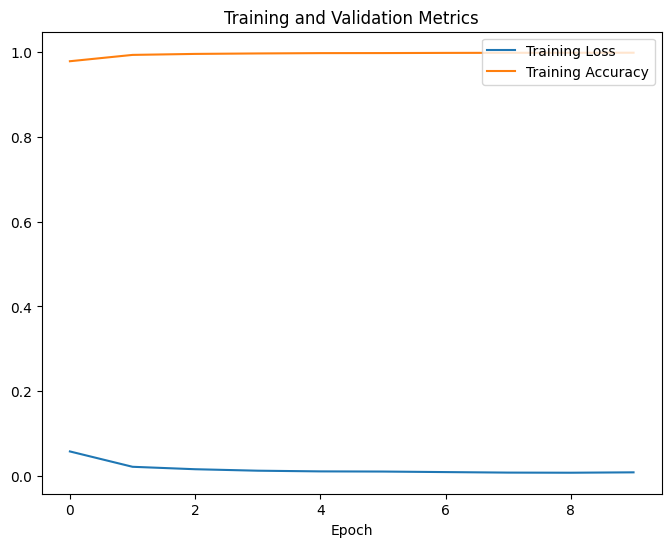

1820/1820 - 6s - 6s/epoch - 3ms/step
Accuracy: 0.999 
Precision: 0.999 
Recall: 0.999
F1 Score: 0.999


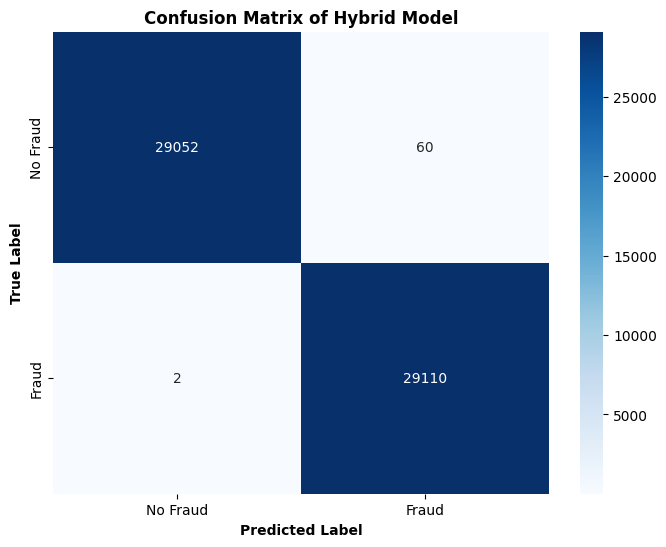

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Assume train_data, lbl_train, test_data, and lbl_test are your training and testing datasets

# Reshape the data for LSTM layer
train_data_lstm = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
test_data_lstm = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))

# Build a hybrid CNN + LSTM model
hybrid_model = Sequential()
hybrid_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_data.shape[1], 1)))
hybrid_model.add(MaxPooling1D(pool_size=2))
hybrid_model.add(LSTM(100, activation='relu', return_sequences=True))
hybrid_model.add(Flatten())
hybrid_model.add(Dense(units=300, activation='relu'))
hybrid_model.add(Dropout(0.5))
hybrid_model.add(Dense(units=200, activation='relu'))
hybrid_model.add(Dense(units=50, activation='relu'))
hybrid_model.add(Dense(units=2, activation='softmax'))

# Compile the model with default settings
hybrid_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Display model architecture
hybrid_model.summary()

# Train the model
hybrid_model_hist = hybrid_model.fit(train_data_lstm, lbl_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot training history
loss = hybrid_model_hist.history['loss']
accuracy = hybrid_model_hist.history['accuracy']
val_loss = hybrid_model_hist.history['val_loss']
val_accuracy = hybrid_model_hist.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), accuracy, label='Training Accuracy')

plt.legend(loc='upper right')
plt.title('Training and Validation Metrics')
plt.xlabel("Epoch")
plt.show()

# Evaluate the model on the test set
y_pred_hybrid = hybrid_model.predict(test_data_lstm, verbose=2)
y_pred_hybrid = np.argmax(y_pred_hybrid, axis=1)
acc = accuracy_score(lbl_test, y_pred_hybrid)
classfi_report = classification_report(lbl_test, y_pred_hybrid, output_dict=True)
pre = classfi_report['macro avg']['precision']
rec = classfi_report['macro avg']['recall']
f1 = classfi_report['macro avg']['f1-score']

print('Accuracy: %.3f ' % acc)
print('Precision: %.3f ' % pre)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

# Plot confusion matrix
plot_cfm(lbl_test, y_pred_hybrid, "Hybrid Model")


LSTM+CNN HYPERPARAMETER

2426/2426 [==============================] - 7s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-16-0864acb4c329>", line 41, in fit
    self.model = create_cnn_lstm_model(self.filters1, self.kernel_size1, self.filters2, self.kernel_size2,
  File "<ipython-input-16-0864acb4c329>", line 13, in create_cnn_lstm_model
    model.add(Conv1D(filters=filters2, kernel_size=kernel_size2, activation=

Best Parameters:  {'lstm_units': 100, 'kernel_size2': 3, 'kernel_size1': 3, 'filters2': 256, 'filters1': 32, 'dropout_rate': 0.5, 'dense_units3': 50, 'dense_units2': 300, 'dense_units1': 200}
Best Accuracy:  0.9977500310339339
1820/1820 [==============================] - 7s 4ms/step
Best Model - Accuracy: 0.998 
Best Model - Precision: 0.998 
Best Model - Recall: 0.998
Best Model - F1 Score: 0.998


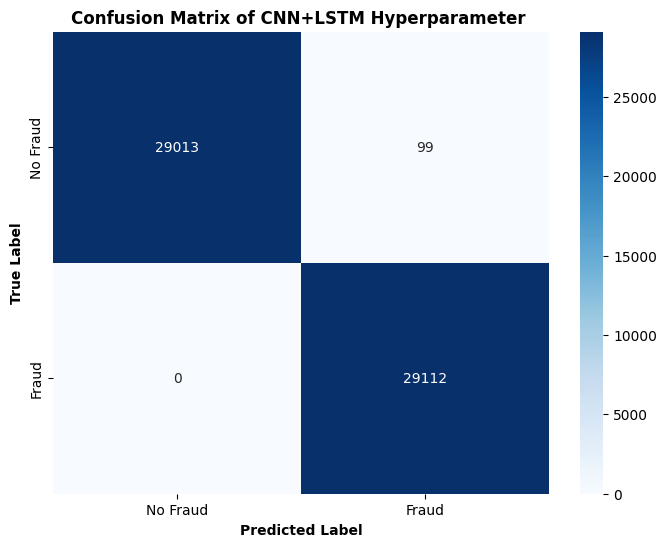

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report

# Define the CNN+LSTM model as a function
def create_cnn_lstm_model(filters1, kernel_size1, filters2, kernel_size2, lstm_units, dense_units1, dropout_rate, dense_units2, dense_units3):
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu', input_shape=(train_data.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=lstm_units, activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=dense_units1, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units2, activation='relu'))
    model.add(Dense(units=dense_units3, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

# Define a wrapper class for the Keras model
class KerasEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, filters1, kernel_size1, filters2, kernel_size2, lstm_units, dense_units1, dropout_rate, dense_units2, dense_units3):
        self.filters1 = filters1
        self.kernel_size1 = kernel_size1
        self.filters2 = filters2
        self.kernel_size2 = kernel_size2
        self.lstm_units = lstm_units
        self.dense_units1 = dense_units1
        self.dropout_rate = dropout_rate
        self.dense_units2 = dense_units2
        self.dense_units3 = dense_units3
        self.model = None

    def fit(self, X, y):
        self.model = create_cnn_lstm_model(self.filters1, self.kernel_size1, self.filters2, self.kernel_size2,
                                           self.lstm_units, self.dense_units1, self.dropout_rate, self.dense_units2, self.dense_units3)
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

# Define hyperparameter space
param_dist = {
    'filters1': [32, 64, 128],
    'kernel_size1': [3, 5],
    'filters2': [64, 128, 256],
    'kernel_size2': [3, 5],
    'lstm_units': [50, 100, 150],
    'dense_units1': [100, 200, 300],
    'dropout_rate': [0.3, 0.5, 0.7],
    'dense_units2': [100, 200, 300],
    'dense_units3': [20, 50, 100]
}

# Create the KerasEstimator
keras_estimator = KerasEstimator(filters1=32, kernel_size1=3, filters2=64, kernel_size2=3,
                                lstm_units=50, dense_units1=100, dropout_rate=0.3, dense_units2=100, dense_units3=20)

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=keras_estimator, param_distributions=param_dist, n_iter=10, cv=3)
random_search_result = random_search.fit(train_data, lbl_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", random_search_result.best_params_)
print("Best Accuracy: ", random_search_result.best_score_)

# Use the best model for evaluation
best_params = random_search_result.best_params_
best_model = KerasEstimator(**best_params).fit(train_data, lbl_train)

y_pred_best = best_model.predict(test_data)
acc_best = accuracy_score(lbl_test, y_pred_best)
classfi_report_best = classification_report(lbl_test, y_pred_best, output_dict=True)
pre_best = classfi_report_best['macro avg']['precision']
rec_best = classfi_report_best['macro avg']['recall']
f1_best = classfi_report_best['macro avg']['f1-score']

print('Best Model - Accuracy: %.3f ' % acc_best)
print('Best Model - Precision: %.3f ' % pre_best)
print('Best Model - Recall: %.3f' % rec_best)
print('Best Model - F1 Score: %.3f' % f1_best)

# Plot confusion matrix using your custom plot_cfm function
plot_cfm(lbl_test, y_pred_best, "CNN+LSTM Hyperparameter ")


1820/1820 [==============================] - 8s 4ms/step
1820/1820 - 4s - 4s/epoch - 2ms/step
Best Model - Accuracy: 0.999 
Best Model - Precision: 0.999 
Best Model - Recall: 0.999
Best Model - F1 Score: 0.999


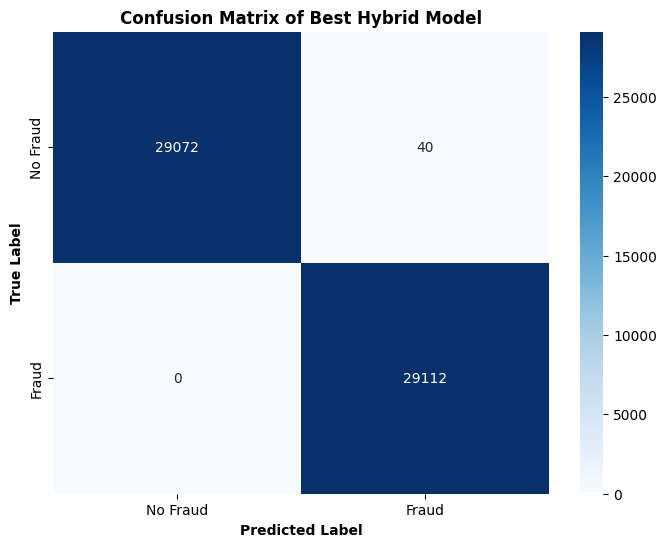

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Function to create the hybrid model
def create_hybrid_model(filters, kernel_size, lstm_units, dense_units, dropout_rate):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(train_data.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(lstm_units, activation='relu', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=200, activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

# Define hyperparameter combinations to try
hyperparameter_combinations = [
    {'filters': 32, 'kernel_size': 3, 'lstm_units': 50, 'dense_units': 100, 'dropout_rate': 0.3},
    {'filters': 64, 'kernel_size': 3, 'lstm_units': 100, 'dense_units': 300, 'dropout_rate': 0.5},
    # Add more combinations as needed
]

best_accuracy = 0.0
best_model = None
best_hyperparameters = None

# Iterate over hyperparameter combinations
for hyperparameters in hyperparameter_combinations:
    model = create_hybrid_model(**hyperparameters)

    # Train the model
    model.fit(train_data, lbl_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate on the validation set
    val_predictions = model.predict(test_data)
    val_predictions = np.argmax(val_predictions, axis=1)
    val_accuracy = accuracy_score(lbl_test, val_predictions)

    # Check if this set of hyperparameters gives a better result
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_hyperparameters = hyperparameters

# Train the best model with the entire training set
best_model.fit(train_data, lbl_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the best model on the test set
y_pred_best = best_model.predict(test_data, verbose=2)
y_pred_best = np.argmax(y_pred_best, axis=1)
acc_best = accuracy_score(lbl_test, y_pred_best)
classfi_report_best = classification_report(lbl_test, y_pred_best, output_dict=True)
pre_best = classfi_report_best['macro avg']['precision']
rec_best = classfi_report_best['macro avg']['recall']
f1_best = classfi_report_best['macro avg']['f1-score']

# Print the best model's evaluation metrics
print('Best Model - Accuracy: %.3f ' % acc_best)
print('Best Model - Precision: %.3f ' % pre_best)
print('Best Model - Recall: %.3f' % rec_best)
print('Best Model - F1 Score: %.3f' % f1_best)

# Plot confusion matrix for the best model
plot_cfm(lbl_test, y_pred_best, "Best Hybrid Model")


# **plot results**

In [ ]:
#------------------------------------------------------Logistic Regression
accuracy_array[0] =  0.9996
precision_array[0] =  0.9992
recall_array[0] = 1.0
f1_score_array[0] = 0.9996

accuracy_array_Hyper[0]=0.9996
precision_array_Hyper[0]= 0.9993
recall_array_Hyper[0]= 0.9999
f1_score_array_Hyper[0]= 0.9996

#----------------------------------------------------Decision Tree
accuracy_array[1] = 0.998
precision_array[1] = 0.998
recall_array[1] = 0.998
f1_score_array[1] = 0.998

accuracy_array_Hyper[1]=0.998
precision_array_Hyper[1]= 0.998
recall_array_Hyper[1]= 0.998
f1_score_array_Hyper[1]= 0.998

#----------------------------------------------------NB

accuracy_array[2] = 0.998
precision_array[2] = 0.925
recall_array[2] = 0.916
f1_score_array[2] = 0.916

accuracy_array_Hyper[2]=0.917
precision_array_Hyper[2]= 0.926
recall_array_Hyper[2]= 0.917
f1_score_array_Hyper[2]= 0.916

#----------------------------------------------------KNN

accuracy_array[3] = 0.917
precision_array[3] = 0.998
recall_array[3] = 0.998
f1_score_array[3] = 0.998

accuracy_array_Hyper[3]=0.999
precision_array_Hyper[3]= 0.999
recall_array_Hyper[3]= 0.999
f1_score_array_Hyper[3]= 0.999
#----------------------------------------------------RF

accuracy_array[4] = 0.998
precision_array[4] = 1.00
recall_array[4] = 1.00
f1_score_array[4] = 1.00

accuracy_array_Hyper[4]=1.00
precision_array_Hyper[4]= 1.00
recall_array_Hyper[4]= 1.00
f1_score_array_Hyper[4]= 1.00
#----------------------------------------------------Adaboost

accuracy_array[5] = 0.944
precision_array[5] = 0.945
recall_array[5] = 0.944
f1_score_array[5] = 0.944

accuracy_array_Hyper[5]=0.968
precision_array_Hyper[5]= 0.968
recall_array_Hyper[5]= 0.968
f1_score_array_Hyper[5]= 0.968

#----------------------------------------------------LSTM

accuracy_array[6] = 0.999
precision_array[6] = 0.999
recall_array[6] = 0.999
f1_score_array[6] = 0.999

accuracy_array_Hyper[6]= 0.998
precision_array_Hyper[6]= 0.998
recall_array_Hyper[6]=  0.998
f1_score_array_Hyper[6]=  0.998

#----------------------------------------------------CNN

accuracy_array[7] = 0.998
precision_array[7] = 0.998
recall_array[7] = 0.998
f1_score_array[7] = 0.998

accuracy_array_Hyper[7]= 0.998
precision_array_Hyper[7]= 0.998
recall_array_Hyper[7]=  0.998
f1_score_array_Hyper[7]=  0.998
#----------------------------------------------------CNN+ LSTM

accuracy_array[8] = 0.999
precision_array[8] = 0.999
recall_array[8] = 0.999
f1_score_array[8] = 0.999

accuracy_array_Hyper[8]= 0.999
precision_array_Hyper[8]= 0.999
recall_array_Hyper[8]=  0.999
f1_score_array_Hyper[8]=  0.999







--------------------result--------------------------


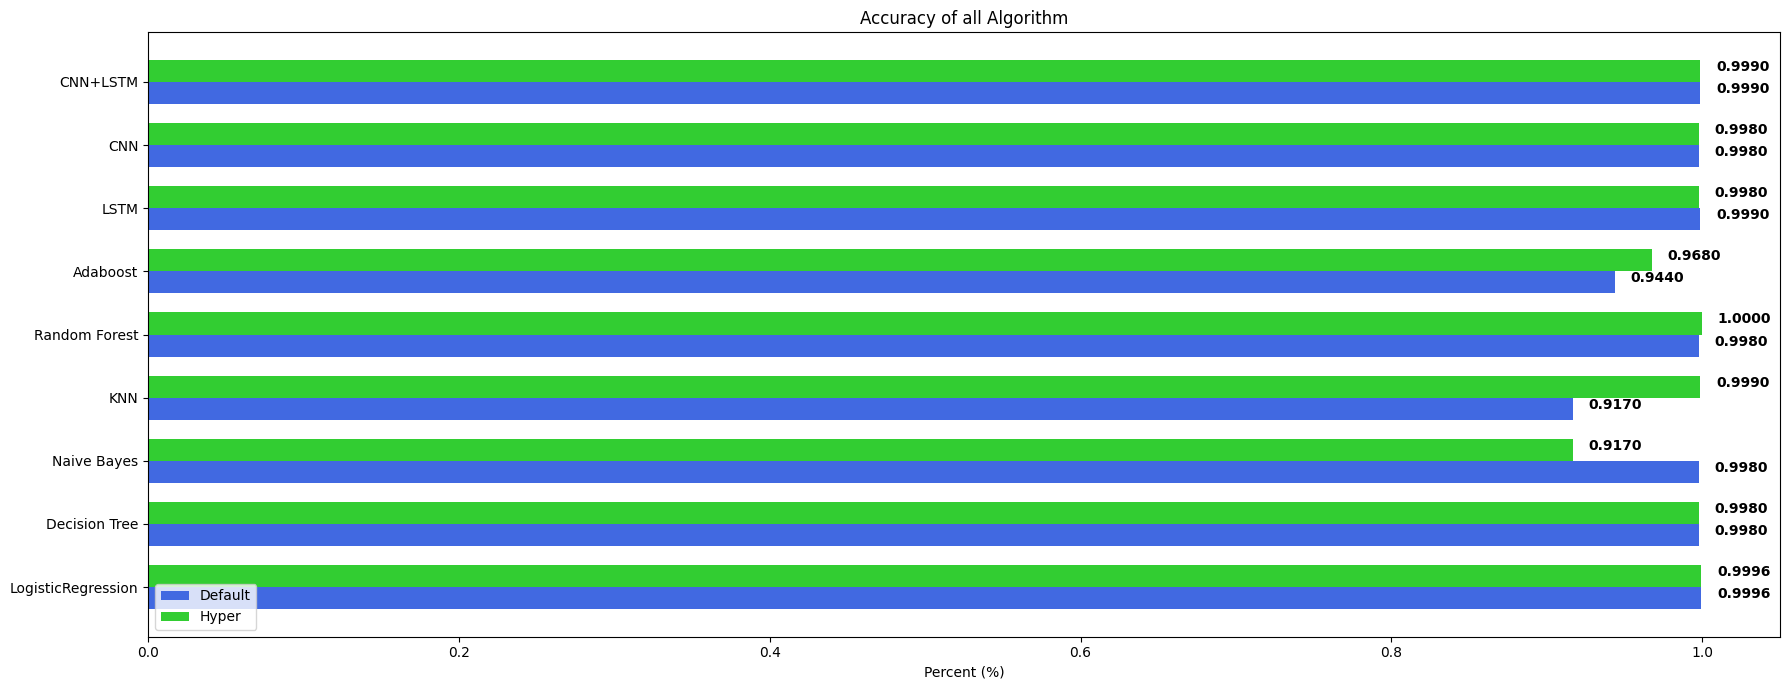

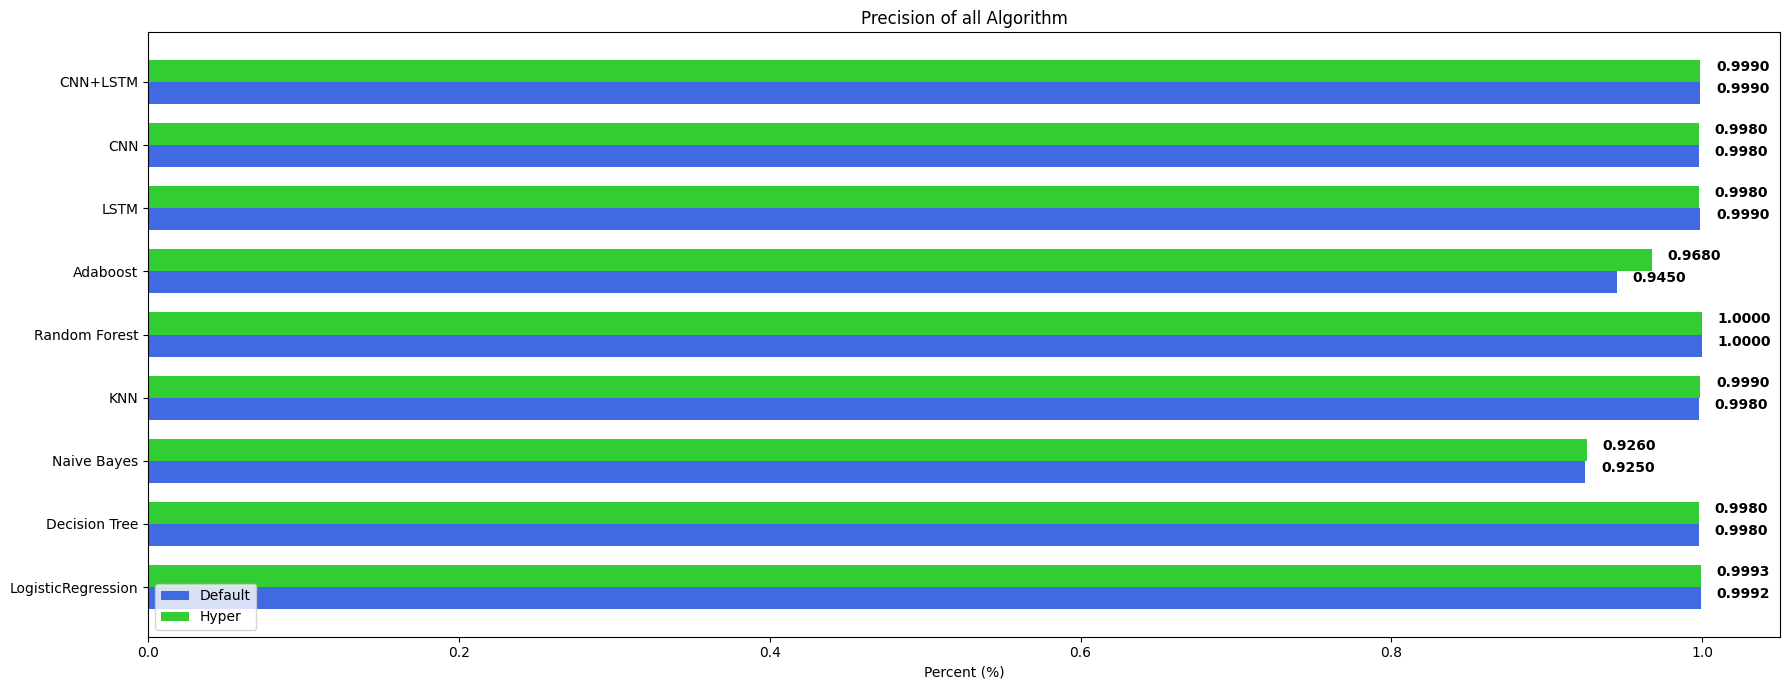

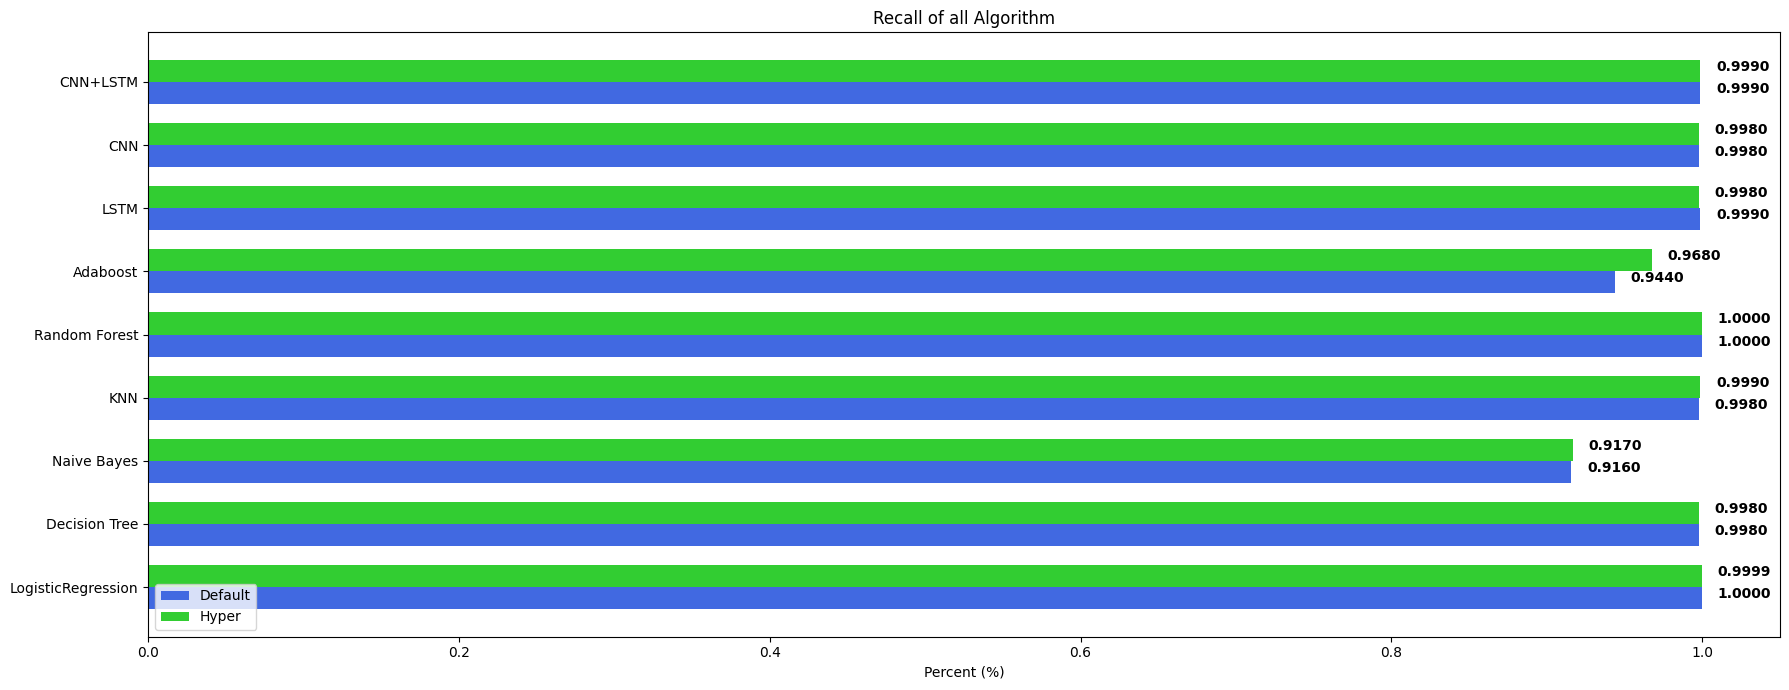

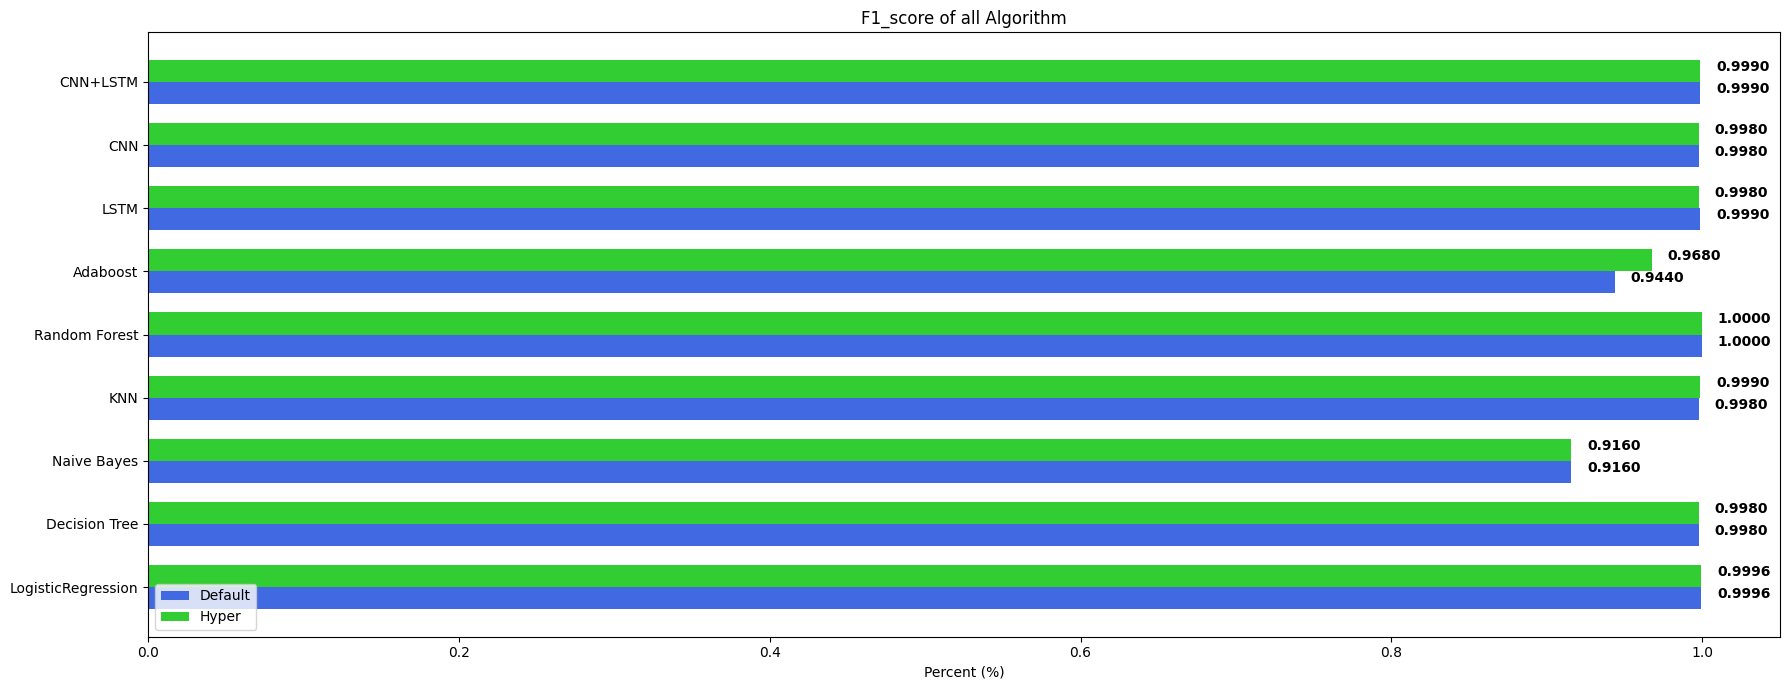

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

H = 18
L = 7

save_path = '/content/drive/MyDrive/'

print('--------------------result--------------------------')
#-----------------------------Accuracy
fig1, ax = plt.subplots(figsize=(H, L))

combined_data = np.array([accuracy_array, accuracy_array_Hyper])

bar_width = 0.35
index = np.arange(len(algorithms_name))
bar_positions = [index + bar_width * i for i in range(len(combined_data))]

for i, (data, color, label) in enumerate(zip(combined_data, ['royalblue', 'limegreen'], ['Default', 'Hyper'])):
    bars = ax.barh(bar_positions[i], data, height=bar_width, color=color, label=label)
    for bar, value in zip(bars, data):
        ax.text(bar.get_x() + bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f"{value:.4f}", color='black', fontweight='bold')

ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(algorithms_name)
ax.set_xlabel('Percent (%)')
ax.set_title('Accuracy of all Algorithm')
ax.legend(loc='lower left')

plt.tight_layout()


fig1.show()
#-----------------------------precision
fig2, ax = plt.subplots(figsize=(H, L))

combined_data = np.array([precision_array, precision_array_Hyper])

bar_width = 0.35
index = np.arange(len(algorithms_name))
bar_positions = [index + bar_width * i for i in range(len(combined_data))]

for i, (data, color, label) in enumerate(zip(combined_data, ['royalblue', 'limegreen'], ['Default', 'Hyper'])):
    bars = ax.barh(bar_positions[i], data, height=bar_width, color=color, label=label)
    for bar, value in zip(bars, data):
        ax.text(bar.get_x() + bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f"{value:.4f}", color='black', fontweight='bold')

ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(algorithms_name)
ax.set_xlabel('Percent (%)')
ax.set_title('Precision of all Algorithm')
ax.legend(loc='lower left')

plt.tight_layout()

fig2.show()

#-----------------------------recall
fig3, ax = plt.subplots(figsize=(H, L))

combined_data = np.array([recall_array, recall_array_Hyper])

bar_width = 0.35
index = np.arange(len(algorithms_name))
bar_positions = [index + bar_width * i for i in range(len(combined_data))]

for i, (data, color, label) in enumerate(zip(combined_data, ['royalblue', 'limegreen'], ['Default', 'Hyper'])):
    bars = ax.barh(bar_positions[i], data, height=bar_width, color=color, label=label)
    for bar, value in zip(bars, data):
        ax.text(bar.get_x() + bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f"{value:.4f}", color='black', fontweight='bold')

ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(algorithms_name)
ax.set_xlabel('Percent (%)')
ax.set_title('Recall of all Algorithm')
ax.legend(loc='lower left')

plt.tight_layout()

fig3.show()
#-----------------------------f1_score
fig4, ax = plt.subplots(figsize=(H, L))

combined_data = np.array([f1_score_array, f1_score_array_Hyper])

bar_width = 0.35
index = np.arange(len(algorithms_name))
bar_positions = [index + bar_width * i for i in range(len(combined_data))]

for i, (data, color, label) in enumerate(zip(combined_data, ['royalblue', 'limegreen'], ['Default', 'Hyper'])):
    bars = ax.barh(bar_positions[i], data, height=bar_width, color=color, label=label)
    for bar, value in zip(bars, data):
        ax.text(bar.get_x() + bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f"{value:.4f}", color='black', fontweight='bold')

ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(algorithms_name)
ax.set_xlabel('Percent (%)')
ax.set_title('F1_score of all Algorithm')
ax.legend(loc='lower left')

plt.tight_layout()

fig4.show()

fig1.savefig(save_path + 'accuracy_plot.png', dpi=1300, bbox_inches='tight')
fig2.savefig(save_path + 'precision_plot.png', dpi=1300, bbox_inches='tight')
fig3.savefig(save_path + 'Recall_plot.png', dpi=1300, bbox_inches='tight')
fig4.savefig(save_path + 'f1_plot.png', dpi=1300, bbox_inches='tight')


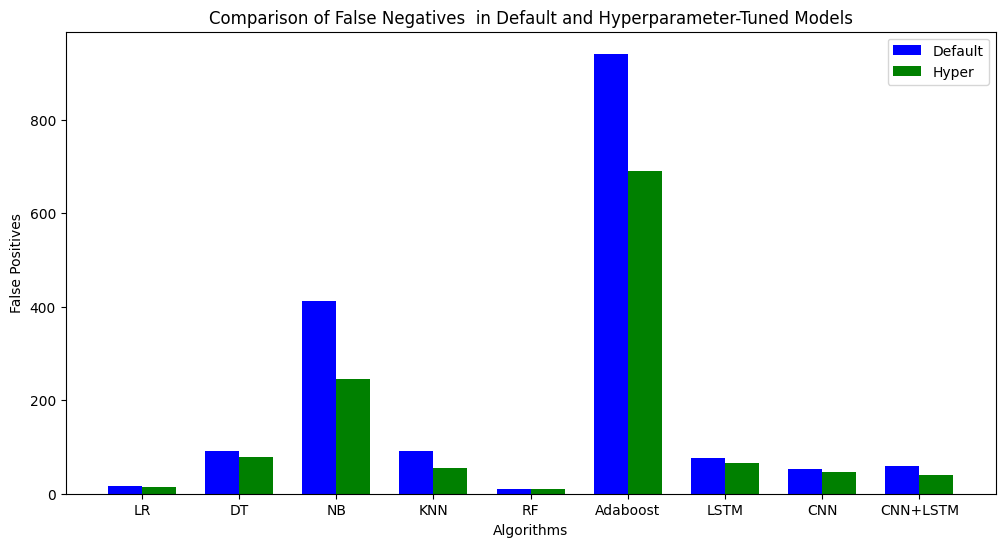

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the algorithms and their False Positive results for default and hyper models
algorithms_name = ['LR', 'DT', 'NB', 'KNN', 'RF', 'Adaboost', 'LSTM', 'CNN', 'CNN+LSTM']
algorithms_name_hyper = ['LR Hyper', 'DT Hyper', 'NB Hyper', 'KNN Hyper', 'RF Hyper', 'Adaboost Hyper', 'LSTM Hyper', 'CNN Hyper', 'CNN+LSTM Hyper']

false_positives_default = np.array([17, 92, 412, 91, 10, 941, 77, 52, 60])
false_positives_hyper = np.array([14, 79, 246, 55, 10, 690, 66, 47, 40])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(algorithms_name))

# Bar chart for default models
bar_default = ax.bar(index, false_positives_default, bar_width, label='Default', color='b')

# Bar chart for hyperparameter-tuned models
bar_hyper = ax.bar(index + bar_width, false_positives_hyper, bar_width, label='Hyper', color='g')

# Add labels, title, and legend
ax.set_xlabel('Algorithms')
ax.set_ylabel('False Positives')
ax.set_title('Comparison of False Negatives  in Default and Hyperparameter-Tuned Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(algorithms_name)
ax.legend()

# Show the plot
plt.show()
plt.savefig(save_path + 'Comparison_FalseNegatives.png', dpi=1300, bbox_inches='tight')

